# Bottled Gazpacho Market Research 4 (0 - 4 scale)

I don't know about you, but I love Gazpacho. In Spain they sell those delicacies bottled in supermarkets. But what about the rest of the world? How sad I am eveytime I go to the supermarket and none of that elixir is available. Here's the wonderful sight that Spaniards take for granted, while everyone else can only dream of:

![gazpacho](./images/spanish_bottled_gazpacho.jpg)

No more! This stops here! Or so I hope. Let's perform some **simulated market research** to find out if there is a market for Gazpacho in the rest of the world.

In [1]:
import json
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, '..')

import tinytroupe
from tinytroupe import config_manager
from tinytroupe.agent import TinyPerson
from tinytroupe.environment import TinyWorld
from tinytroupe.factory import TinyPersonFactory
from tinytroupe.validation import TinyPersonValidator
from tinytroupe import control

from tinytroupe.extraction import ResultsExtractor
from tinytroupe.profiling import Profiler

from tinytroupe.validation import SimulationExperimentEmpiricalValidator, SimulationExperimentDataset, validate_simulation_experiment_empirically


!!!!
DISCLAIMER: TinyTroupe relies on Artificial Intelligence (AI) models to generate content. 
The AI models are not perfect and may produce inappropriate or inacurate results. 
For any serious or consequential use, please review the generated content before using it.
!!!!

Looking for default config on: C:\Users\pdasilva\repos\TinyTroupe\examples\..\tinytroupe\utils\..\config.ini
Found custom config on: C:\Users\pdasilva\repos\TinyTroupe\examples\config.ini
TinyTroupe version: 0.5.1
Current date and time (local): 2025-07-26 13:51:26
Current date and time (UTC):   2025-07-26 16:51:26

Current TinyTroupe configuration 
[OpenAI]
api_type = openai
azure_api_version = 2024-08-01-preview
model = gpt-4.1-mini
reasoning_model = o3-mini
embedding_model = text-embedding-3-small
max_tokens = 32000
temperature = 1.5
freq_penalty = 0.1
presence_penalty = 0.1
timeout = 480
max_attempts = 5
waiting_time = 0
exponential_backoff_factor = 5
reasoning_effort = high
cache_api_calls = False
cache_file_n

In [2]:
config_manager.update("action_generator_enable_quality_checks", True)
config_manager.update("action_generator_quality_threshold", 6)

First of all, we'll use a cached simulation, to avoid having to recompute expensive steps unless really necessary. We accomplish this via the `control.begin()` function. The file it takes as an argument is the cache file that will be created and then updated as needed.

**Tip:** the ".cache." naming convention is used to indicate that the file is a cache file and will not be committed to the repository.

In [3]:
control.begin("bottled_gazpacho_market_research_4b.cache.json")

## Prepare the survey and auxiliary elements

Main target nationality and population size.

In [4]:
target_nationality = "American"
population_size = 50

additional_demographic_specification = f"""
BESIDES other dimensions infered from the population demographic data (i.e., make sure those are still present), 
ensure these ADDITIONAL sampling dimensions are present, which must be as realistic as possible:
  - general attitude: from positive to negative, from optimistic to pessimistic, from open-minded to closed-minded
  - education: from the completely illiterate (can't even talk properly) to the highest scientist
  - culinary tastes: from traditional to modern, from spicy to mild, from vegetarian to meat-based
  - shopping habits: from frequent to occasional, from online to in-store, from frugal to extravagant
  - health consciousness: from health-focused to indulgent, from organic to conventional
  - attitude towards new products: from open-minded to skeptical, from adventurous to conservative
  - cultural influences: from local to global, from traditional to contemporary, from diverse to homogeneous
  - travel habits: from frequent travelers to homebodies, from local to international, from adventurous to cautious
  - cultural background: from diverse to homogeneous, from traditional to modern, from local to global
  - lifestyle: from active to sedentary, from urban to rural, from minimalist to extravagant

Each of these additional dimensions MUST have AT LEAST 10 values. 
For all of these, YOU MUST provide long, detailed sentences that describe the values in each dimension. NOT short
words. We need EACH value to be VERY detailed.

Make sure you also include EXTREME values so that we can properly capture even edge cases. We want a WIDE
range of different people and tastes!
"""
  

Should we also compute the other nationalities? This might take a while, so we leave it as an option.

In [5]:
compute_other_nationalities = True

Descriptions and standard questions for the survey.

In [6]:
interviewer_introduction =\
    """
    We are performing some market research and need to know you more. 
    Can you please present yourself and also list your top-10 interests?
    """

interviewer_main_question =\
    """ 
    Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with tomatoes, cucumbers, peppers, and olive oil. 
    We are considering offering it in supermarkets near you.

    Would you consider purchasing ready-to-drink bottled gazpacho if it was available at your local supermarket? How much do you like this idea? 

    Please rate your propensity of purchasing it (from 1 to 5), where:
       - 1: would NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
       - 2: very unlikely, but not impossible.
       - 3: maybe I would buy it, not sure.
       - 4: it is very likely.
       - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how you feel, as it is part of the human experience.
    """

inner_monologue =\
    """
    I will be honest as I understand they are not here to judge me, but just to learn from me. 
    Such choices depend on many factors, but I will make my best guess, considering my current 
    situation in life, location, job and interests. I will not refrain from giving extreme answers, 
    such as 1 or 5, if that's how I really feel, as this exercise requires me to be honest, human and realistic.

    Now I **must** first THINK deeply about the question, consider all the factors that might influence my decision,
    and only then I will TALK with my response to the question as best, as detailed and as honestly as I can.
    """

Common mechaniss.

In [7]:
results_extractor = ResultsExtractor(extraction_objective="Find whether the person would buy the product. A person rate his/her propensity from 1 (would NEVER buy) to 5 (would CERTAINLY buy it)." ,
                                     situation="Agent was asked to rate their interest in a bottled Gazpacho. They can respond with a propensity score from 1 (would NEVER buy) to 5 (would CERTAINLY buy it).", 
                                     fields=["name", "response", "justification"],
                                     fields_hints={"response": "Must be a string formatted exactly as '1', '2', '3', '4', '5' or 'N/A'(if there is no response or you cannot determine the precise response)."},
                                     verbose=True)

A function that will give us the statistics and then recommend us if we should go ahead and start a Gazpacho business.

In [8]:
def is_there_a_good_market(df, positive_threshold=0.1, negative_threshold=0.5):
    # Convert responses to strings for consistent handling
    df_copy = df.copy()
    df_copy["response"] = df_copy["response"].astype(str)
    
    # Get counts and calculate percentages
    counts = df_copy["response"].value_counts()
    total = counts.sum()
    percentage = counts / total
    
    # Calculate percentages by rating category (using 1-5 scale)
    percentage_positive = percentage.get("4", 0) + percentage.get("5", 0)
    percentage_neutral = percentage.get("3", 0)
    percentage_negative = percentage.get("1", 0) + percentage.get("2", 0)
    percentage_na = percentage.get("N/A", 0)
    
    # Print the analysis
    print(f"Percentage of positive responses (4-5): {percentage_positive:.2%}")
    print(f"Percentage of neutral responses (3): {percentage_neutral:.2%}")
    print(f"Percentage of negative responses (1-2): {percentage_negative:.2%}")
    print(f"Percentage of 'N/A' responses: {percentage_na:.2%}")

    # also compute the mean and standard deviation of the responses
    df_copy["response"] = pd.to_numeric(df_copy["response"], errors='coerce')
    mean_response = df_copy["response"].mean()
    std_response = df_copy["response"].std()

    print(f"Mean response: {mean_response:.2f}")
    print(f"Standard deviation of responses: {std_response:.2f}")

    # Decision based on thresholds
    if percentage_positive > positive_threshold and percentage_negative < negative_threshold:
        print("VERDICT: There is a good market for bottled gazpacho.")
        return True
    else:
        print("VERDICT: There is not a good market for bottled gazpacho.")
        return False



## Build the audience

Summon an audience out of thin simulated air. To do so, we build a factory whose context defines our problem and target audience. Actual agents will be later sampled from this factory.

In [9]:
factory = TinyPersonFactory.create_factory_from_demography("./information/populations/usa.json", 
                                                           population_size=population_size, 
                                                           additional_demographic_specification=additional_demographic_specification)

In [10]:
people = factory.generate_people(population_size, verbose=True)

2025-07-26 13:51:57,604 - tinytroupe - ERROR - Could not generate person 46/50. Continuing with the remaining ones.


2025-07-26 13:51:57,607 - tinytroupe - ERROR - Could not generate person 47/50. Continuing with the remaining ones.


2025-07-26 13:51:57,608 - tinytroupe - ERROR - Could not generate person 50/50. Continuing with the remaining ones.


2025-07-26 13:51:57,611 - tinytroupe - ERROR - Could not generate person 49/50. Continuing with the remaining ones.


In [11]:
factory.sampling_dimensions

{'sampling_space_description': 'A comprehensive sampling space representing the diverse population of the United States of America, capturing detailed demographic, socioeconomic, cultural, personality, political, and lifestyle characteristics with proportions reflecting the latest demographic data and enriched with nuanced, detailed descriptive values for each dimension.',
 'dimensions': [{'name': 'age', 'range': [0, 100]},
  {'name': 'gender', 'values': {'Male': 0.492, 'Female': 0.508}},
  {'name': 'racial_and_ethnic_composition',
   'values': {'White (Non-Hispanic)': 0.571,
    'Hispanic or Latino': 0.194,
    'Black or African American': 0.121,
    'Asian': 0.07,
    'Two or More Races': 0.029,
    'American Indian or Alaska Native': 0.013,
    'Native Hawaiian or Pacific Islander': 0.002}},
  {'name': 'educational_attainment',
   'values': {'Completely illiterate, unable to speak properly or read basic texts': 0.1,
    'Basic literacy with limited reading and writing skills': 0.15,

In [12]:
factory.sampling_plan

[{'id': 1,
  'subpopulation_description': 'Young urban White (Non-Hispanic) males with high education and middle to upper-middle income, open to new experiences and politically independent.',
  'sampled_values': {'age': [18, 35],
   'gender': ['Male'],
   'racial_and_ethnic_composition': ['White (Non-Hispanic)'],
   'educational_attainment': ["Bachelor's degree with specialized knowledge in a field",
    'Graduate or professional degree with advanced expertise and research experience'],
   'household_income': ['Middle income between $50,000 and $99,999',
    'Upper-middle income between $100,000 and $199,999'],
   'geographic_distribution': ['Urban residents living in densely populated metropolitan areas with access to diverse amenities and services'],
   'personality_traits': ['Individuals with high openness to experience, embracing new ideas and cultural diversity, often found in New York and California',
    'Highly conscientious individuals, diligent and organized, prevalent in Kan

We can request a specific number of people.

A quick look into the folks that were created:

In [13]:
factory.generated_minibios

['Calvin Theodore Ashford is a 29 year old Senior Data Scientist, American, currently living in Brooklyn, New York City, NY, USA. Beyond his professional expertise, Calvin is a thoughtful and introspective individual who values deep, meaningful conversations and intellectual curiosity. He enjoys exploring diverse cultures through travel and cuisine, often experimenting with fusion recipes at home. A moderate introvert, he prefers quality time with close friends and engaging in activities like attending jazz clubs, visiting museums, or hosting board game nights. His commitment to ethical data use and urban sustainability reflects a strong sense of social responsibility, which he also expresses through volunteering and writing about the intersection of technology and social impact.',
 'Mateo Alejandro Vargas Herrera is a 44 year old Registered Nurse and Community Health Worker, Mexican, currently living in Houston, Texas, USA. Mateo is a warm and conscientious individual who balances his

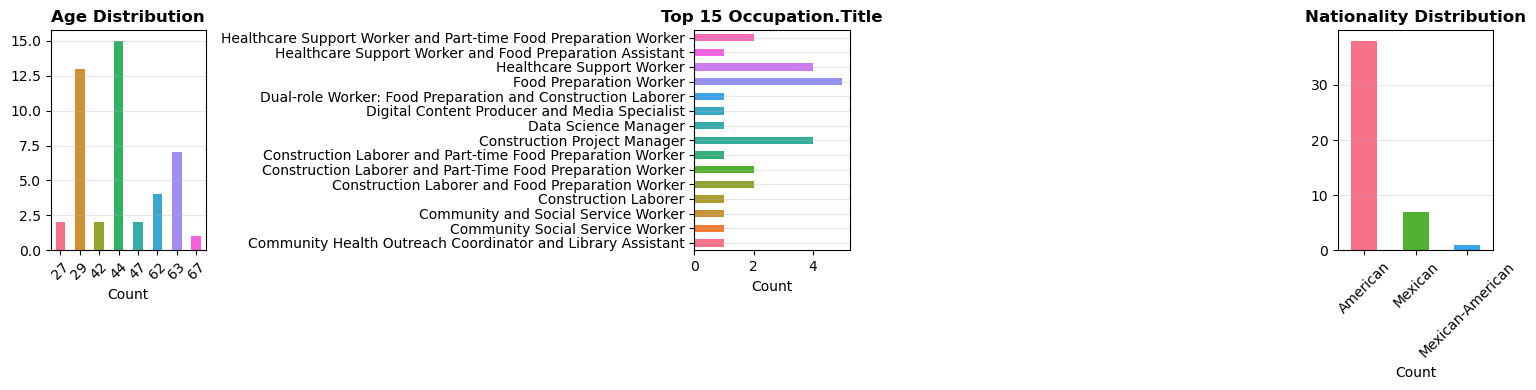

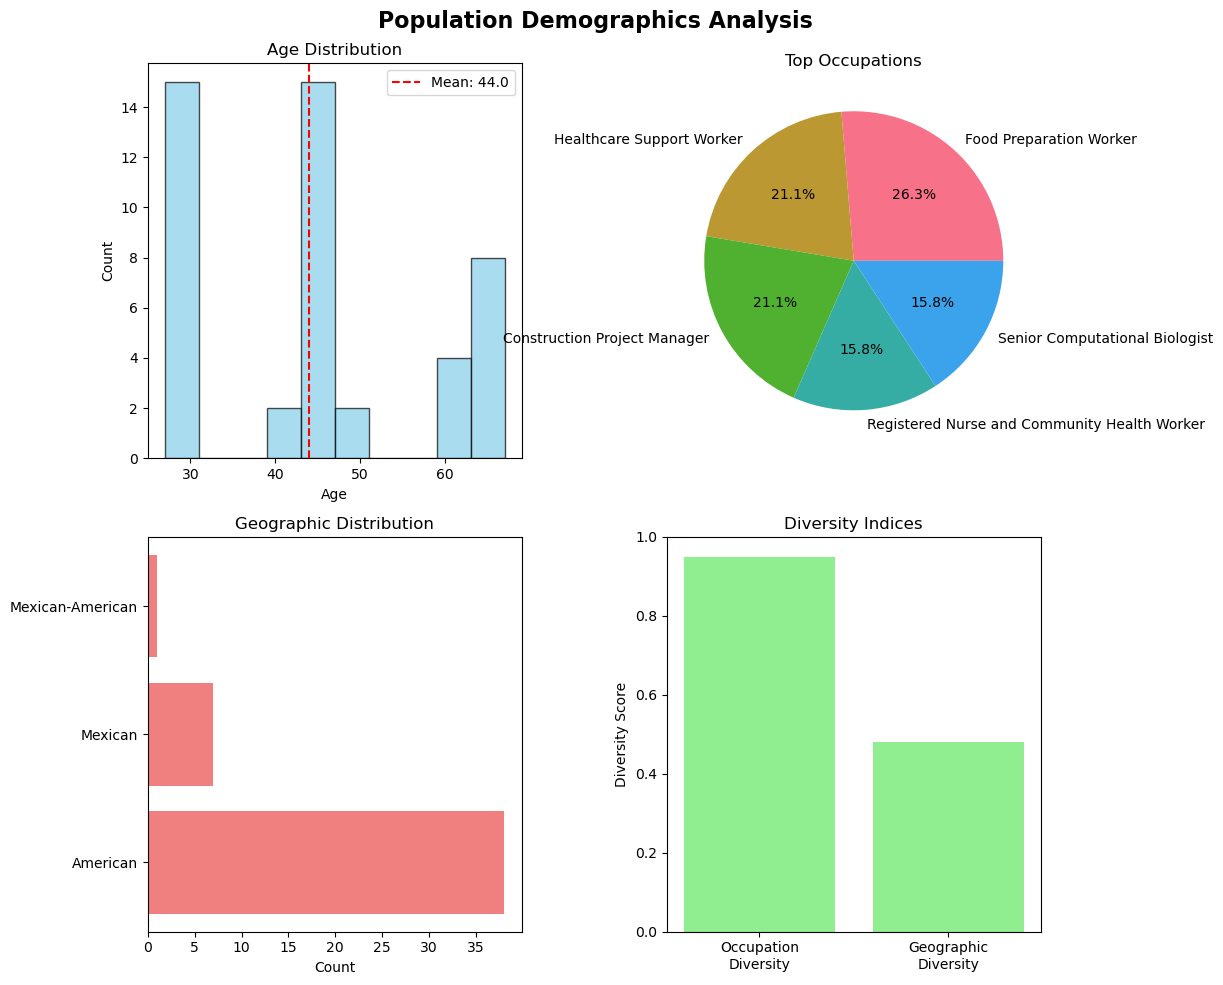

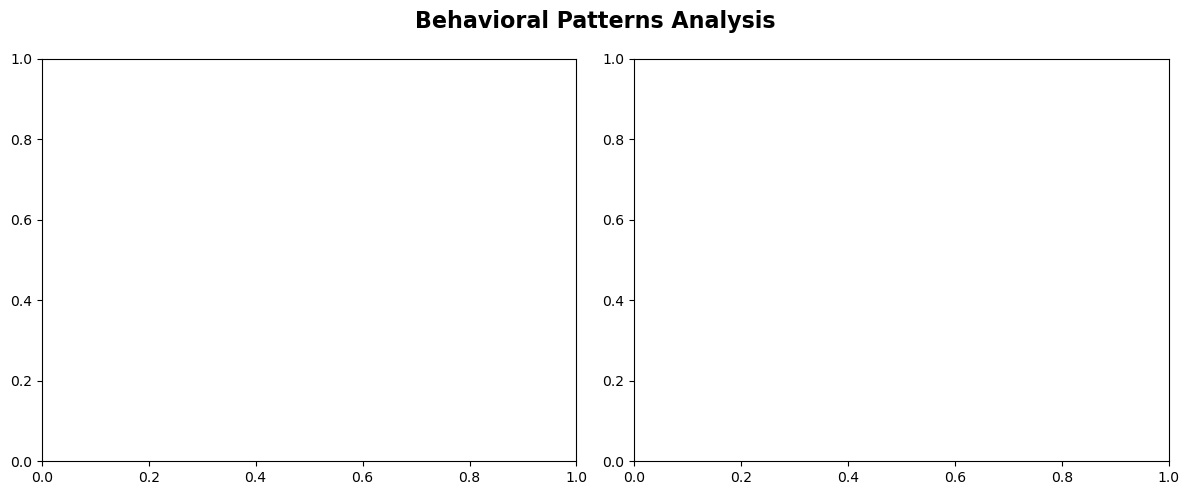

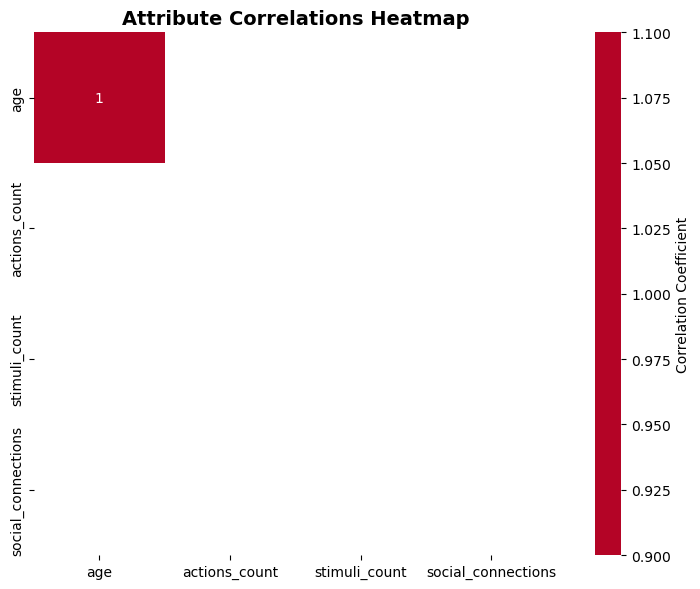

{'distributions': {'age': 27     2
  29    13
  42     2
  44    15
  47     2
  62     4
  63     7
  67     1
  Name: count, dtype: int64,
  'occupation.title': Community Health Outreach Coordinator and Library Assistant        1
  Community Social Service Worker                                    1
  Community and Social Service Worker                                1
  Construction Laborer                                               1
  Construction Laborer and Food Preparation Worker                   2
  Construction Laborer and Part-Time Food Preparation Worker         2
  Construction Laborer and Part-time Food Preparation Worker         1
  Construction Project Manager                                       4
  Data Science Manager                                               1
  Digital Content Producer and Media Specialist                      1
  Dual-role Worker: Food Preparation and Construction Laborer        1
  Food Preparation Worker                                 

In [14]:
profiler = Profiler()
profiler.profile(people)

Checkpoint the simulation state to disk, to avoid having to re-run the expensive agent sampling process, unless really necessary.

In [15]:
control.checkpoint()

Now let's enclose the audience in an environment, to make it easier to interact with. Note that we set `broadcast_if_no_target` to `False`, which instructs the environment to **do not** broadcast what specific agents say to the others (unless the agent deliberately specify the target). We are not simulating a focus group, so we don't want discussions.


In [16]:
market = TinyWorld(f"Target audience ({target_nationality})", people, broadcast_if_no_target=False)

## Perform the research

Now we actually ask agents about their opinion. Note that we are asking for specific answers (Yes, No, Maybe), both to convey the granularity of preference we seek, and to make it easier to extract the results later. In general, a coarser granuarity is likely to have higher quality, since it requires less information to be computed accurately.

In [17]:
market.broadcast(interviewer_introduction)
market.broadcast(interviewer_main_question)
market.broadcast_thought(inner_monologue)

USER --> Calvin Theodore Ashford: [CONVERSATION] 
          >      We are performing some market research and need to know you more.      Can you
          > please present yourself and also list your top-10 interests?

       + --> Mateo Alejandro Vargas Herrera

       + --> Ethan Marshall Granger

       + --> ...others...

USER --> Calvin Theodore Ashford: [CONVERSATION] 
          >       Gazpacho is a cold, blended vegetable soup originally from Spain, made mainly with
          > tomatoes, cucumbers, peppers, and olive oil.      We are considering offering it in
          > supermarkets near you.      Would you consider purchasing ready-to-drink bottled
          > gazpacho if it was available at your local supermarket? How much do you like this idea?
          > Please rate your propensity of purchasing it (from 1 to 5), where:        - 1: would
          > NEVER buy it. Note that IT IS OK to give this extreme and impulsive answer if it is how
          > you feel, as it is part of the human experience.        - 2: very unlikely, but not
          > impossible.        - 3: maybe I would buy it, not sure.        - 4: it is very likely.
          > - 5: would CERTAINLY buy it. Note that IT IS OK to give this extreme and impulsive
          > answer if it is how you feel, as it is part of the human experience.

       + --> Mateo Alejandro Vargas Herrera

       + --> Ethan Marshall Granger

       + --> ...others...

Calvin Theodore Ashford --> Calvin Theodore Ashford: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Mateo Alejandro Vargas Herrera --> Mateo Alejandro Vargas Herrera: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Ethan Marshall Granger --> Ethan Marshall Granger: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Clarence Darnell Whitfield --> Clarence Darnell Whitfield: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Clara Meredith Hargrove --> Clara Meredith Hargrove: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Loretta Janice Freeman --> Loretta Janice Freeman: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Isabel Mariela Torres Delgado --> Isabel Mariela Torres Delgado: [THOUGHT] 
                                   >      I will be honest as I understand they are not here to
                                   > judge me, but just to learn from me.      Such choices depend
                                   > on many factors, but I will make my best guess, considering my
                                   > current      situation in life, location, job and interests. I
                                   > will not refrain from giving extreme answers,      such as 1 or
                                   > 5, if that's how I really feel, as this exercise requires me to
                                   > be honest, human and realistic.      Now I **must** first THINK
                                   > deeply about the question, consider all the factors that might
                                   > influence my decision,     and only then I will TALK with my
                                   > response to the question as best, as detailed and as honestly
                                   > as I can.

Mabel Louise Cartwright --> Mabel Louise Cartwright: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Wesley Grant Carmichael --> Wesley Grant Carmichael: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Jordan Kai Navarro-Simms --> Jordan Kai Navarro-Simms: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Evelyn Margaret Hensley --> Evelyn Margaret Hensley: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Gideon Marshall Treadwell --> Gideon Marshall Treadwell: [THOUGHT] 
                               >      I will be honest as I understand they are not here to judge
                               > me, but just to learn from me.      Such choices depend on many
                               > factors, but I will make my best guess, considering my current
                               > situation in life, location, job and interests. I will not refrain
                               > from giving extreme answers,      such as 1 or 5, if that's how I
                               > really feel, as this exercise requires me to be honest, human and
                               > realistic.      Now I **must** first THINK deeply about the
                               > question, consider all the factors that might influence my
                               > decision,     and only then I will TALK with my response to the
                               > question as best, as detailed and as honestly as I can.

Isabel Cristina Mendoza Rivera --> Isabel Cristina Mendoza Rivera: [THOUGHT] 
                                    >      I will be honest as I understand they are not here to
                                    > judge me, but just to learn from me.      Such choices depend
                                    > on many factors, but I will make my best guess, considering my
                                    > current      situation in life, location, job and interests. I
                                    > will not refrain from giving extreme answers,      such as 1
                                    > or 5, if that's how I really feel, as this exercise requires
                                    > me to be honest, human and realistic.      Now I **must**
                                    > first THINK deeply about the question, consider all the
                                    > factors that might influence my decision,     and only then I
                                    > will TALK with my response to the question as best, as
                                    > detailed and as honestly as I can.

Thomas Red Elk --> Thomas Red Elk: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.

Mildred Joyce Hargis --> Mildred Joyce Hargis: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Nalani Kealoha Makoa --> Nalani Kealoha Makoa: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Caroline Meredith Hargrove --> Caroline Meredith Hargrove: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Lucía Maribel Domínguez --> Lucía Maribel Domínguez: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Mariana Estela Rivas --> Mariana Estela Rivas: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Emilio Javier Salazar Ortega --> Emilio Javier Salazar Ortega: [THOUGHT] 
                                  >      I will be honest as I understand they are not here to judge
                                  > me, but just to learn from me.      Such choices depend on many
                                  > factors, but I will make my best guess, considering my current
                                  > situation in life, location, job and interests. I will not
                                  > refrain from giving extreme answers,      such as 1 or 5, if
                                  > that's how I really feel, as this exercise requires me to be
                                  > honest, human and realistic.      Now I **must** first THINK
                                  > deeply about the question, consider all the factors that might
                                  > influence my decision,     and only then I will TALK with my
                                  > response to the question as best, as detailed and as honestly as
                                  > I can.

Gloria Annette Jefferson --> Gloria Annette Jefferson: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Leroy Darnell McKnight --> Leroy Darnell McKnight: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Elliot Bradford Winslow --> Elliot Bradford Winslow: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Gideon Everett Langston --> Gideon Everett Langston: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Isabel Marisol Herrera --> Isabel Marisol Herrera: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Vivian Adelaide Carmichael --> Vivian Adelaide Carmichael: [THOUGHT] 
                                >      I will be honest as I understand they are not here to judge
                                > me, but just to learn from me.      Such choices depend on many
                                > factors, but I will make my best guess, considering my current
                                > situation in life, location, job and interests. I will not refrain
                                > from giving extreme answers,      such as 1 or 5, if that's how I
                                > really feel, as this exercise requires me to be honest, human and
                                > realistic.      Now I **must** first THINK deeply about the
                                > question, consider all the factors that might influence my
                                > decision,     and only then I will TALK with my response to the
                                > question as best, as detailed and as honestly as I can.

Trenton Wade Calloway --> Trenton Wade Calloway: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Harold Darnell McCoy --> Harold Darnell McCoy: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Malcolm Jerome Tate --> Malcolm Jerome Tate: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Clara Bethany Winslow --> Clara Bethany Winslow: [THOUGHT] 
                           >      I will be honest as I understand they are not here to judge me,
                           > but just to learn from me.      Such choices depend on many factors,
                           > but I will make my best guess, considering my current      situation in
                           > life, location, job and interests. I will not refrain from giving
                           > extreme answers,      such as 1 or 5, if that's how I really feel, as
                           > this exercise requires me to be honest, human and realistic.      Now I
                           > **must** first THINK deeply about the question, consider all the
                           > factors that might influence my decision,     and only then I will TALK
                           > with my response to the question as best, as detailed and as honestly
                           > as I can.

Nisha Aria Takahashi --> Nisha Aria Takahashi: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Caleb Harrison Whitfield --> Caleb Harrison Whitfield: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Elijah Running Bear --> Elijah Running Bear: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Sahana Priya Desai --> Sahana Priya Desai: [THOUGHT] 
                        >      I will be honest as I understand they are not here to judge me, but
                        > just to learn from me.      Such choices depend on many factors, but I
                        > will make my best guess, considering my current      situation in life,
                        > location, job and interests. I will not refrain from giving extreme
                        > answers,      such as 1 or 5, if that's how I really feel, as this
                        > exercise requires me to be honest, human and realistic.      Now I
                        > **must** first THINK deeply about the question, consider all the factors
                        > that might influence my decision,     and only then I will TALK with my
                        > response to the question as best, as detailed and as honestly as I can.

Dorothy Mae Hensley --> Dorothy Mae Hensley: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Anika Mei-Ling Chen --> Anika Mei-Ling Chen: [THOUGHT] 
                         >      I will be honest as I understand they are not here to judge me, but
                         > just to learn from me.      Such choices depend on many factors, but I
                         > will make my best guess, considering my current      situation in life,
                         > location, job and interests. I will not refrain from giving extreme
                         > answers,      such as 1 or 5, if that's how I really feel, as this
                         > exercise requires me to be honest, human and realistic.      Now I
                         > **must** first THINK deeply about the question, consider all the factors
                         > that might influence my decision,     and only then I will TALK with my
                         > response to the question as best, as detailed and as honestly as I can.

Derek Franklin Caldwell --> Derek Franklin Caldwell: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Rafael Ignacio Morales Cruz --> Rafael Ignacio Morales Cruz: [THOUGHT] 
                                 >      I will be honest as I understand they are not here to judge
                                 > me, but just to learn from me.      Such choices depend on many
                                 > factors, but I will make my best guess, considering my current
                                 > situation in life, location, job and interests. I will not
                                 > refrain from giving extreme answers,      such as 1 or 5, if
                                 > that's how I really feel, as this exercise requires me to be
                                 > honest, human and realistic.      Now I **must** first THINK
                                 > deeply about the question, consider all the factors that might
                                 > influence my decision,     and only then I will TALK with my
                                 > response to the question as best, as detailed and as honestly as
                                 > I can.

Margaret Elaine Whitmore --> Margaret Elaine Whitmore: [THOUGHT] 
                              >      I will be honest as I understand they are not here to judge me,
                              > but just to learn from me.      Such choices depend on many factors,
                              > but I will make my best guess, considering my current      situation
                              > in life, location, job and interests. I will not refrain from giving
                              > extreme answers,      such as 1 or 5, if that's how I really feel,
                              > as this exercise requires me to be honest, human and realistic.
                              > Now I **must** first THINK deeply about the question, consider all
                              > the factors that might influence my decision,     and only then I
                              > will TALK with my response to the question as best, as detailed and
                              > as honestly as I can.

Calvin Everett Hargrove --> Calvin Everett Hargrove: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Avery Simone Delgado --> Avery Simone Delgado: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Garrett Milton Prescott --> Garrett Milton Prescott: [THOUGHT] 
                             >      I will be honest as I understand they are not here to judge me,
                             > but just to learn from me.      Such choices depend on many factors,
                             > but I will make my best guess, considering my current      situation
                             > in life, location, job and interests. I will not refrain from giving
                             > extreme answers,      such as 1 or 5, if that's how I really feel, as
                             > this exercise requires me to be honest, human and realistic.      Now
                             > I **must** first THINK deeply about the question, consider all the
                             > factors that might influence my decision,     and only then I will
                             > TALK with my response to the question as best, as detailed and as
                             > honestly as I can.

Leilani Kahele --> Leilani Kahele: [THOUGHT] 
                    >      I will be honest as I understand they are not here to judge me, but just
                    > to learn from me.      Such choices depend on many factors, but I will make my
                    > best guess, considering my current      situation in life, location, job and
                    > interests. I will not refrain from giving extreme answers,      such as 1 or
                    > 5, if that's how I really feel, as this exercise requires me to be honest,
                    > human and realistic.      Now I **must** first THINK deeply about the
                    > question, consider all the factors that might influence my decision,     and
                    > only then I will TALK with my response to the question as best, as detailed
                    > and as honestly as I can.

Jaden Marcellus Vega --> Jaden Marcellus Vega: [THOUGHT] 
                          >      I will be honest as I understand they are not here to judge me, but
                          > just to learn from me.      Such choices depend on many factors, but I
                          > will make my best guess, considering my current      situation in life,
                          > location, job and interests. I will not refrain from giving extreme
                          > answers,      such as 1 or 5, if that's how I really feel, as this
                          > exercise requires me to be honest, human and realistic.      Now I
                          > **must** first THINK deeply about the question, consider all the factors
                          > that might influence my decision,     and only then I will TALK with my
                          > response to the question as best, as detailed and as honestly as I can.

Miriam Esther Goldfarb --> Miriam Esther Goldfarb: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

Eleanor Rosenthal Katz --> Eleanor Rosenthal Katz: [THOUGHT] 
                            >      I will be honest as I understand they are not here to judge me,
                            > but just to learn from me.      Such choices depend on many factors,
                            > but I will make my best guess, considering my current      situation
                            > in life, location, job and interests. I will not refrain from giving
                            > extreme answers,      such as 1 or 5, if that's how I really feel, as
                            > this exercise requires me to be honest, human and realistic.      Now
                            > I **must** first THINK deeply about the question, consider all the
                            > factors that might influence my decision,     and only then I will
                            > TALK with my response to the question as best, as detailed and as
                            > honestly as I can.

In [18]:
market.run(1)

───────────────────────────────────── Target audience (American) step 1 of 1 ──────────────────────────────────────

Jordan Kai Navarro-Simms acts: [DONE] 

Evelyn Margaret Hensley acts: [THINK] 
                             > Considering my lifestyle, dietary preferences, and the fact that I
                             > enjoy fresh, wholesome foods, I think about how gazpacho fits into my
                             > routine. I appreciate nutritious meals and often cook from scratch,
                             > but convenience is also important given my busy schedule. Gazpacho,
                             > being a cold vegetable soup, sounds refreshing and healthy,
                             > especially during warmer months. However, I am cautious about
                             > processed or pre-packaged foods and prefer natural ingredients. I
                             > must weigh these factors carefully before deciding how likely I would
                             > be to purchase ready-to-drink bottled gazpacho.

Clara Meredith Hargrove acts: [THINK] 
                             > I need to consider my lifestyle, preferences, and the practicality of
                             > buying ready-to-drink gazpacho. Given my interest in cooking and
                             > fresh ingredients, I usually prefer homemade meals, but convenience
                             > can be appealing on busy days. Gazpacho is not a common dish in my
                             > usual diet, but I appreciate healthy options and fresh vegetables. I
                             > should weigh how likely I am to purchase it regularly or
                             > occasionally, considering my health-conscious habits and dislike for
                             > highly processed foods.

Isabel Mariela Torres Delgado acts: [THINK] 
                                   > I need to consider my lifestyle, preferences, and cultural
                                   > background before answering about buying bottled gazpacho. I
                                   > usually prefer fresh, homemade foods, especially traditional
                                   > Mexican dishes. Gazpacho is not a common dish in my culture,
                                   > and I might find it unusual. However, if it were convenient and
                                   > tasty, I might consider trying it. I also have to think about
                                   > my budget and whether this product fits into it. Given these
                                   > factors, I think my propensity to buy would be moderate, maybe
                                   > a 3, because I'm open to trying new things but cautious about
                                   > spending on unfamiliar products.

Wesley Grant Carmichael acts: [THINK] 
                             > I need to consider my personal preferences, lifestyle, and typical
                             > food choices before answering about gazpacho. Given my preference for
                             > hearty American fare like grilled meats and barbecue, and my dislike
                             > for unfamiliar or exotic cuisines, I am skeptical about ready-to-
                             > drink gazpacho. Also, cold vegetable soups are not something I
                             > usually consume. However, I should be honest and rate my propensity
                             > realistically based on these factors.

Mateo Alejandro Vargas Herrera acts: [THINK] 
                                    > I need to consider my personal preferences, cultural
                                    > background, and lifestyle when deciding about purchasing
                                    > ready-to-drink bottled gazpacho. Gazpacho is a cold vegetable
                                    > soup from Spain, which is not a traditional dish in my Mexican
                                    > heritage, but I do appreciate fresh and healthy foods. I also
                                    > think about convenience since I have a busy schedule as a
                                    > nurse and community health worker. However, I prefer freshly
                                    > made foods and dislike processed foods. I should weigh these
                                    > factors carefully before giving my rating.

Clarence Darnell Whitfield acts: [THINK] 
                                > I reckon I gotta be honest 'bout this gazpacho thing. Ain't never
                                > had it before, and it sounds kinda fancy for around here. I like
                                > my food simple and warm, like fried catfish or collard greens.
                                > Bottled cold soup just don't sit right with me, but I gotta think
                                > if maybe folks 'round here might buy it. Still, I ain't much for
                                > newfangled stuff or things that ain't part of our tradition. So I
                                > gotta figure if I'd even consider buying it or not.

Ethan Marshall Granger acts: [THINK] 
                            > Alright, lemme think this through. Gazpacho's a cold veggie soup from
                            > Spain, right? Tomatoes, cucumbers, peppers, olive oil. Sounds kinda
                            > fancy for around here. I ain't used to cold soups much, especially
                            > bottled ones. I like hearty, warm meals, like burgers or stews. Plus,
                            > I ain't sure if I'd trust a ready-to-drink bottled soup from the
                            > store. But maybe on a hot day it could be alright. Still, I gotta be
                            > honest, I probably wouldn't buy it much. So, on that 1 to 5 scale, I'd
                            > say 2. Very unlikely, but not impossible if I was curious or it was
                            > cheap enough. Yeah, that sounds about right.

Calvin Theodore Ashford acts: [THINK] 
                             > Considering my lifestyle in Brooklyn, my interest in diverse
                             > cuisines, and my preference for authentic, fresh foods, I need to
                             > evaluate how a ready-to-drink bottled gazpacho fits into my habits.
                             > Gazpacho is a Spanish cold soup, which aligns with my appreciation
                             > for Mediterranean flavors. However, I usually prefer fresh or freshly
                             > prepared meals over processed or bottled options. Also, I dislike
                             > overly processed snacks and fast food, so that might influence my
                             > willingness to buy such a product. On the other hand, convenience is
                             > important given my busy schedule as a senior data scientist. I should
                             > weigh these factors carefully before giving a rating.

Mabel Louise Cartwright acts: [THINK] 
                             > I reckon I should think about this gazpacho thing real careful-like.
                             > It ain't somethin' folks 'round here usually drink, especially cold
                             > soups from faraway places like Spain. I like my food warm and home-
                             > cooked, like the biscuits and pies I bake. But I gotta be honest and
                             > consider if it might be handy or tasty enough to buy ready-made. I
                             > don't much care for fancy or unfamiliar foods, and I prefer simple,
                             > traditional meals. So, I might lean towards not buying it, but I
                             > gotta weigh if it could be useful on a hot day or for a quick meal.
                             > I'll think on this a bit more before I answer.

Loretta Janice Freeman acts: [THINK] 
                            > Alright, lemme think 'bout this gazpacho thing real careful-like. I
                            > ain't too familiar with it, but I know it's a cold soup from Spain
                            > made with veggies like tomatoes and cucumbers. Now, I usually prefer
                            > home-cooked meals, especially soul food, and I don't like processed or
                            > fast foods much. Also, cold foods ain't always my favorite, especially
                            > if they ain't familiar. But I do care 'bout healthy options and fresh
                            > veggies. Considering my cautious nature and preference for routine, I
                            > might be hesitant to try somethin' new like bottled gazpacho. On the
                            > other hand, if it's convenient and tastes good, maybe I'd consider it.
                            > So, I reckon my likelihood to buy it would be around a 2, very
                            > unlikely but not impossible. I gotta be honest 'bout my feelings here.

Gideon Marshall Treadwell acts: [THINK] 
                               > Alright, I gotta think this through. Gazpacho's a cold veggie soup
                               > from Spain, huh? Not really something I grew up with or usually
                               > eat. Around here, I prefer hearty, warm meals, especially with
                               > meat. Plus, I'm not big on fancy or unfamiliar foods. But I get
                               > that some folks might like it. Considering my tastes and habits,
                               > I'd probably be pretty unlikely to buy bottled gazpacho at the
                               > supermarket. Maybe a 2 on that scale. I don't wanna flat out say
                               > never, but it's just not my thing. Now I gotta put this into words
                               > and say it straight.

Jordan Kai Navarro-Simms acts: [THINK] 
                              > Alright, let's break this down. Gazpacho is a cold vegetable soup
                              > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I
                              > like fresh, authentic flavors and multicultural cuisines, so that
                              > fits my interests. But I also have a mild allergy to shellfish, so I
                              > have to be careful with new foods, though gazpacho doesn't have
                              > shellfish. I usually prefer fresh or homemade food over processed or
                              > bottled versions, but convenience sometimes wins out, especially
                              > with my busy freelance schedule. I also dislike overly
                              > commercialized or chain products lacking character, so the brand and
                              > quality would matter. Considering all this, I think I'd rate my
                              > propensity to buy ready-to-drink bottled gazpacho as a 3: maybe I'd
                              > buy it, not sure. It depends on the taste and authenticity, but I'm
                              > open to trying it.

Evelyn Margaret Hensley acts: [TALK] 
                             > Thank you for explaining about gazpacho. Considering my preference
                             > for fresh and wholesome foods, and my cautiousness about processed
                             > items, I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 3. I might buy it occasionally, especially during
                             > warmer months when a cold, refreshing soup sounds appealing, but I
                             > would want to check the ingredients to ensure it's made with natural,
                             > high-quality components.

Clara Meredith Hargrove acts: [TALK] 
                             > Thank you for explaining. Considering my preference for fresh,
                             > homemade meals and my general dislike for highly processed foods, I
                             > would rate my propensity to purchase ready-to-drink gazpacho as a 2.
                             > It's not impossible that I might try it occasionally, especially if
                             > it's made with quality ingredients and fits into a healthy diet, but
                             > I would be very unlikely to buy it regularly.

Wesley Grant Carmichael acts: [TALK] 
                             > Honestly, I'd rate my propensity to buy ready-to-drink bottled
                             > gazpacho as a 1. I prefer hearty American foods like grilled meats
                             > and barbecue, and cold vegetable soups just aren't my thing. It seems
                             > a bit too unfamiliar and not really suited to my tastes or lifestyle.

Jordan Kai Navarro-Simms acts: [TALK] 
                              > Honestly, I'd say a 3. I mean, gazpacho sounds fresh and fits my
                              > love for multicultural cuisines, but I'm kinda picky about bottled
                              > stuff. If it's authentic and tastes good, maybe I'd grab it
                              > sometimes, but I usually prefer fresh or homemade. So yeah, maybe
                              > I'd buy it, not sure though.

Calvin Theodore Ashford acts: [TALK] 
                             > Given my appreciation for Mediterranean flavors and fresh foods, I
                             > would rate my propensity to purchase ready-to-drink bottled gazpacho
                             > as a 3. I might buy it occasionally, especially if it's made with
                             > high-quality, natural ingredients, but I generally prefer freshly
                             > prepared meals over bottled options. Convenience is a factor, but I
                             > remain somewhat cautious about processed products.

Mabel Louise Cartwright acts: [THINK] 
                             > I been thinkin' on that gazpacho question some more. I don't rightly
                             > like cold soups much, and it ain't part of our usual fare 'round
                             > here. I prefer warm, home-cooked meals, like the chicken and dumplins
                             > or a good pie. But I reckon on a hot summer day, it might be
                             > refreshing for some folks. Still, I ain't sure I'd buy it myself,
                             > 'cause it don't fit with what I like or what I usually eat. So, I
                             > figure my answer's gonna be low on the scale, maybe a 2, 'cause I
                             > can't say never, but it's mighty unlikely I'd buy it.

Mateo Alejandro Vargas Herrera acts: [TALK] 
                                    > I appreciate the idea of having ready-to-drink bottled
                                    > gazpacho available, especially since it's a healthy option.
                                    > However, I usually prefer freshly made foods and tend to avoid
                                    > processed items. Considering my busy schedule, convenience is
                                    > important, but I would rate my propensity to purchase it as a
                                    > 3 — maybe I would buy it, but I'm not sure yet.

Ethan Marshall Granger acts: [TALK] 
                            > Look, I gotta be straight with ya. I ain't much into that bottled
                            > gazpacho stuff. Cold veggie soup just ain't my thing, especially in a
                            > bottle. I'd probably give it a 2 on your scale—very unlikely to buy
                            > it, but I ain't sayin' never. Maybe if it was cheap or I was real
                            > curious, I'd try it once. But mostly, I stick to hearty, warm meals
                            > that fill me up after a long day of work. So yeah, not really sold on
                            > this idea.

Isabel Mariela Torres Delgado acts: [TALK] 
                                   > Thank you for explaining about gazpacho. Honestly, I think I
                                   > would rate my likelihood of buying ready-to-drink bottled
                                   > gazpacho as a 3. I like to try new foods sometimes, but since
                                   > gazpacho is not a traditional dish for me and I usually prefer
                                   > fresh, homemade meals, I'm a bit unsure. If it tastes good and
                                   > is convenient, I might buy it occasionally, but it wouldn't be
                                   > a regular purchase for me.

Wesley Grant Carmichael acts: [DONE] 

Thomas Red Elk acts: [THINK] 
                    > I consider my lifestyle here on the reservation, my preference for traditional
                    > foods and simple, hearty meals. Gazpacho is a cold, blended vegetable soup
                    > from Spain, which is quite different from the foods I usually eat. I am
                    > cautious about unfamiliar foods and processed meals, and I prefer to avoid
                    > dependence on modern technology and convenience foods. Given my dislike for
                    > unfamiliar foods and preference for traditional cooking, I feel unlikely to
                    > purchase ready-to-drink bottled gazpacho. However, I must be honest and give a
                    > clear answer based on my feelings and situation.

Calvin Theodore Ashford acts: [THINK] 
                             > I need to consider my personal preferences, lifestyle, and cultural
                             > background to answer honestly about purchasing ready-to-drink bottled
                             > gazpacho. Given my interest in diverse cuisines and my experience
                             > traveling in Spain, I appreciate authentic flavors. However, I also
                             > dislike overly processed foods and prefer fresh ingredients. I should
                             > weigh these factors carefully before giving a rating.

Mabel Louise Cartwright acts: [TALK] 
                             > Well, I gotta be honest, I ain't much for cold soups like gazpacho.
                             > It ain't somethin' we usually have 'round here, and I prefer warm,
                             > home-cooked meals. So, if I had to rate my likeliness to buy it, I'd
                             > say a 2. It's not impossible, but mighty unlikely I'd pick it up at
                             > the store.

Clarence Darnell Whitfield acts: [THINK] 
                                > I been thinkin' 'bout that gazpacho question some more. I ain't
                                > much for cold soups, especially bottled ones. Around here, we like
                                > our food cooked fresh and warm. But I reckon some folks might be
                                > curious 'bout it. Still, I gotta be honest with myself and say I
                                > probably wouldn't buy it. It just don't fit with what I like or
                                > what we usually eat 'round these parts.

Loretta Janice Freeman acts: [TALK] 
                            > Well, I gotta be honest, I ain't too sure 'bout buyin' that bottled
                            > gazpacho. I usually stick to home-cooked meals and I don't really like
                            > processed stuff much. So, I'd say my chance of buyin' it is a 2, very
                            > unlikely but not impossible. I just gotta be careful with new things,
                            > you know?

Mateo Alejandro Vargas Herrera acts: [THINK] 
                                    > I need to consider my personal preferences, cultural
                                    > background, and lifestyle when deciding about purchasing
                                    > ready-to-drink bottled gazpacho. Gazpacho is a Spanish cold
                                    > soup, and while I appreciate traditional Latin American
                                    > dishes, this is not something I usually consume. I also think
                                    > about the convenience factor and health aspects. Given my
                                    > interest in fresh ingredients and dislike for processed foods,
                                    > I might be hesitant. However, if it is made with fresh,
                                    > natural ingredients and tastes good, I could consider it. I
                                    > should rate my propensity honestly, balancing my cautiousness
                                    > with openness to new foods.

Isabel Cristina Mendoza Rivera acts: [THINK] 
                                    > I need to consider my personal preferences, cultural
                                    > background, and lifestyle when deciding about purchasing
                                    > ready-to-drink bottled gazpacho. Gazpacho is not a traditional
                                    > dish in Mexican cuisine, and I usually prefer warm, freshly
                                    > made meals. However, I do appreciate fresh ingredients and
                                    > healthy options. I also think about convenience since I have a
                                    > busy schedule working at the clinic and bakery. I should weigh
                                    > these factors carefully before giving my rating.

Isabel Mariela Torres Delgado acts: [THINK] 
                                   > I was asked earlier to present myself and list my top-10
                                   > interests. I should respond to that now, giving a warm and
                                   > clear introduction about who I am, my work, and my main
                                   > interests, reflecting my personality and style. I will mention
                                   > my bilingual skills, my jobs in healthcare support and food
                                   > preparation, and my love for traditional Latin American cooking
                                   > and community involvement. I will also list my top interests
                                   > such as cooking, caring for my dogs, listening to regional
                                   > Mexican music, attending cultural festivals, gardening, reading
                                   > bilingual children's books, and others that are important to
                                   > me.

Ethan Marshall Granger acts: [THINK] 
                            > Alright, lemme think this through. Gazpacho's a cold veggie soup from
                            > Spain, huh? Tomatoes, cucumbers, peppers, olive oil. Sounds kinda
                            > fancy for around here. I ain't used to cold soups much, especially
                            > bottled ones. I like hearty, warm meals, like burgers or stews. Plus,
                            > I ain't sure if I'd trust a ready-to-drink bottled soup from the
                            > store. But maybe on a hot day it could be alright. Still, I gotta be
                            > honest, I probably wouldn't buy it much. So on that scale from 1 to 5,
                            > I'd say 2. Very unlikely, but not impossible if I was curious or it
                            > was cheap enough. Yeah, that sounds about right.

Clara Meredith Hargrove acts: [TALK] 
                             > Hello, I'm Clara Meredith Hargrove. I work part-time as a Community
                             > Health Outreach Coordinator at a local clinic and as a Library
                             > Assistant at the Chicago Public Library. I focus on adult education
                             > programs, health literacy, and community wellness. As for my top 10
                             > interests, they include reading a wide range of materials, cooking
                             > and baking diverse recipes, attending local cultural events,
                             > gardening small urban plots, volunteering for literacy and health
                             > campaigns, listening to folk and soft rock music from the 70s and
                             > 80s, exploring historical documentaries and podcasts, practicing
                             > mindfulness and light yoga, engaging in book clubs, and trying new
                             > coffee blends at independent coffee shops.

Gideon Marshall Treadwell acts: [TALK] 
                               > Honestly, I ain't much into that bottled gazpacho stuff. Around
                               > here, we like our meals warm and hearty, with some meat in 'em. I'd
                               > say I'm a 2 on that scale—very unlikely to buy it, but I ain't
                               > sayin' never. Just don't see it fit for my taste or lifestyle.

Evelyn Margaret Hensley acts: [TALK] 
                             > Hello, I'm Evelyn Margaret Hensley. I work as a Medical Library
                             > Technician and Healthcare Support Specialist at the Metropolitan
                             > Health and Learning Center in Chicago. I help healthcare
                             > practitioners and patients access medical literature and educational
                             > resources, manage our library collections, and support patient
                             > education. I'm 44 years old, originally from Missouri, and I live in
                             > Chicago.   As for my top 10 interests, they are: reading a wide range
                             > of materials including contemporary fiction and medical journals;
                             > cooking and baking, especially experimenting with recipes from
                             > various cultures; engaging in community volunteer work related to
                             > education and healthcare; gardening small indoor plants and herbs;
                             > listening to classical music and soft jazz; attending local cultural
                             > events and lectures on history and social issues; practicing
                             > mindfulness and light yoga; exploring new coffee shops and bakeries;
                             > watching documentaries about American history and healthcare
                             > innovations; and participating in book clubs  (...)

Mabel Louise Cartwright acts: [DONE] 

Clara Meredith Hargrove acts: [DONE] 

Gideon Marshall Treadwell acts: [DONE] 

Calvin Theodore Ashford acts: [TALK] 
                             > Considering my appreciation for Mediterranean flavors and fresh,
                             > authentic foods, I would rate my propensity to purchase ready-to-
                             > drink bottled gazpacho as a 3. I might try it occasionally if it's
                             > made with quality ingredients, but I generally prefer freshly
                             > prepared meals over bottled options due to my preference for less
                             > processed foods.

Thomas Red Elk acts: [TALK] 
                    > I would rate my propensity to purchase ready-to-drink bottled gazpacho as 2.
                    > It is very unlikely I would buy it, as I prefer traditional, simple foods and
                    > am cautious about unfamiliar, processed meals. I appreciate the effort to
                    > offer new products, but this one does not fit well with my tastes or
                    > lifestyle.

Mateo Alejandro Vargas Herrera acts: [TALK] 
                                    > I think I would rate my propensity to purchase ready-to-drink
                                    > bottled gazpacho as a 2. While I appreciate fresh and healthy
                                    > foods, I usually prefer freshly made dishes and tend to avoid
                                    > processed or bottled options. Convenience is important given
                                    > my busy schedule, but I would be very unlikely to buy it
                                    > unless I knew it was made with fresh, natural ingredients and
                                    > tasted authentic.

Isabel Cristina Mendoza Rivera acts: [TALK] 
                                    > Thank you for explaining about gazpacho. Honestly, I am not
                                    > very familiar with it since it's not a traditional dish in my
                                    > culture. I usually prefer warm, homemade meals, but I do like
                                    > fresh and healthy foods. Considering my busy schedule, having
                                    > a ready-to-drink option could be convenient. So, I would rate
                                    > my propensity to purchase it as a 3 — maybe I would buy it,
                                    > but I'm not sure yet.

Evelyn Margaret Hensley acts: [TALK] 
                             > Thank you for sharing the details about gazpacho. Considering my
                             > preferences for fresh, wholesome foods and my cautiousness about
                             > processed products, I would rate my likelihood of purchasing ready-
                             > to-drink bottled gazpacho as a 3. I might buy it occasionally,
                             > especially during warmer months when a cold, refreshing soup sounds
                             > appealing, but I would want to check the ingredients to ensure it's
                             > made with natural, high-quality components.

Loretta Janice Freeman acts: [THINK] 
                            > Now I gotta think 'bout presentin' myself and listin' my top-10
                            > interests like they asked. I gotta keep it simple and honest, speakin'
                            > in my usual way. I work as a healthcare support worker in Brooklyn,
                            > helpin' out nurses and doctors, takin' care of patients, and tryin' to
                            > keep things clean and calm. I like readin', takin' care of my cats and
                            > parakeet, listenin' to gospel music, watchin' local news, goin' to
                            > church when I can, cookin' soul food, and volunteerin' sometimes. I
                            > also like gard'nin on my balcony and collectin' bookmarks. I gotta be
                            > careful to sound like me, with my Brooklyn accent and cautious tone.

Isabel Mariela Torres Delgado acts: [TALK] 
                                   > Hola, soy Isabel Mariela Torres Delgado. Tengo 44 años y soy
                                   > mexicana, viviendo en Houston, Texas. Trabajo medio tiempo como
                                   > asistente de apoyo en salud en una clínica comunitaria y
                                   > también en la preparación de alimentos para un servicio de
                                   > catering local. Me gusta mucho cocinar platillos tradicionales
                                   > latinoamericanos y cuidar a mis dos perritos. Mis principales
                                   > intereses incluyen cocinar y hornear recetas mexicanas, cuidar
                                   > a mis perros, escuchar música regional mexicana como ranchera y
                                   > cumbia, asistir a festivales culturales, jardinería de hierbas
                                   > en mi balcón, leer libros bilingües para niños, explorar
                                   > parques urbanos, y participar en actividades comunitarias.
                                   > También disfruto socializar con amigos cercanos y aprender
                                   > nuevas recetas de otros países latinoamericanos.

Ethan Marshall Granger acts: [TALK] 
                            > Look, I ain't much into that bottled gazpacho stuff. Cold veggie soup
                            > in a bottle just ain't my thing. I'd probably give it a 2 on your
                            > scale—very unlikely to buy it, but I ain't sayin' never. Maybe if it
                            > was cheap or I was real curious, I'd try it once. Mostly, I stick to
                            > hearty, warm meals after a long day of work. So yeah, not really sold
                            > on this idea.

Clarence Darnell Whitfield acts: [TALK] 
                                > Well now, I gotta be straight with ya. I ain't never been one for
                                > cold, bottled soups like that gazpacho y'all talkin' 'bout. Around
                                > here, we like our food cooked fresh and warm, somethin' hearty and
                                > familiar. So if I had to give it a number, I'd say 1 — I would
                                > never buy it. Just ain't my kind of thing, and I reckon most folks
                                > 'round here feel the same way. But I appreciate y'all askin' and
                                > tryin' to bring new things to the table.

Mildred Joyce Hargis acts: [THINK] 
                          > I reckon I gotta think 'bout this here gazpacho idea real careful-like.
                          > Bein' from a rural part of Tennessee, I ain't used to fancy cold soups
                          > like that. I mostly stick to my traditional Southern cookin'—biscuits,
                          > stews, and such. Gazpacho sounds kinda foreign and unfamiliar, and I
                          > don't rightly trust newfangled foods much. But I also gotta consider if
                          > it might be handy or tasty for folks 'round here. Still, I tend to avoid
                          > unfamiliar foods and prefer home-cooked meals. So, I figure my likin'
                          > for bottled gazpacho would be pretty low, maybe a 1 or 2. I gotta be
                          > honest 'bout that. Now I need to put this thinkin' into words and share
                          > my answer.

Caroline Meredith Hargrove acts: [THINK] 
                                > Considering my lifestyle, preferences, and the fact that I enjoy
                                > cooking and experimenting with recipes, I think I might be open to
                                > trying ready-to-drink bottled gazpacho. However, I prefer fresh
                                > and homemade meals, and I am cautious about processed foods. Also,
                                > I like Mediterranean cuisine, so gazpacho fits that interest.
                                > Given these factors, I would rate my propensity to purchase it as
                                > a 3, maybe I would buy it, but I'm not sure yet.

Nalani Kealoha Makoa acts: [THINK] 
                          > Okay, so gazpacho is a cold veggie soup from Spain, huh? I gotta think
                          > about if I'd buy that ready-to-drink bottled version at my local
                          > supermarket here in Honolulu. I like fresh, sweet, and tangy flavors,
                          > especially poke bowls and tropical fruits. Gazpacho sounds kinda
                          > different from what I'm used to, but I do like trying new foods
                          > sometimes. Still, I don't usually go for cold soups or drinks like that.
                          > Also, I gotta consider if it's convenient and affordable. Since I work
                          > in food prep and know about fresh ingredients, I'd probably be cautious
                          > about bottled stuff. But if it's tasty and easy to grab on the go, maybe
                          > I'd give it a try. Overall, I think my rating would be a 3, maybe I'd
                          > buy it but not sure yet.

Isabel Cristina Mendoza Rivera acts: [DONE] 

Evelyn Margaret Hensley acts: [DONE] 

Ethan Marshall Granger acts: [DONE] 

Isabel Mariela Torres Delgado acts: [DONE] 

Calvin Theodore Ashford acts: [THINK] 
                             > Reflecting on the question about purchasing ready-to-drink bottled
                             > gazpacho, I consider my culinary interests, preference for fresh and
                             > authentic foods, and my dislike for overly processed products. Given
                             > these factors, I lean towards a moderate interest rather than strong
                             > enthusiasm or outright rejection. I should express this balanced view
                             > honestly in my response.

Clarence Darnell Whitfield acts: [DONE] 

Thomas Red Elk acts: [TALK] 
                    > I am Thomas Red Elk, a community support aide working with the Tribal Social
                    > Services Department. I help elders and families access healthcare, housing
                    > aid, and educational resources. I am deeply connected to my tribal traditions
                    > and prefer a simple, nature-connected lifestyle. My top ten interests include
                    > hiking in nearby hills and forests, fishing in local rivers and lakes,
                    > storytelling and listening to tribal elders, attending tribal ceremonies and
                    > powwows, collecting and using medicinal herbs, woodworking and crafting simple
                    > tools, gardening native plants, cooking traditional meals over open fire,
                    > volunteering at tribal youth programs, and preserving oral histories.

Mateo Alejandro Vargas Herrera acts: [TALK] 
                                    > I appreciate the idea of ready-to-drink bottled gazpacho, but
                                    > considering my preference for fresh, homemade foods and my
                                    > dislike for processed items, I would rate my propensity to
                                    > purchase it as a 2. It's not impossible, but I'm very unlikely
                                    > to buy it unless I know it's made with fresh, natural
                                    > ingredients and tastes authentic.

Loretta Janice Freeman acts: [TALK] 
                            > Hi, I'm Loretta Janice Freeman. I work as a healthcare support worker
                            > at the Urban Community Health Clinic here in Brooklyn. I help nurses
                            > and doctors by takin' care of patients, takin' vital signs, and
                            > keepin' things clean and organized. As for my interests, I enjoy
                            > readin' all kinds of books, takin' care of my two elderly cats and my
                            > little parakeet, listenin' to gospel and soul music from back in the
                            > day, watchin' local news and political commentary, attendin' church
                            > services when I can, cookin' traditional soul food, volunteerin' at
                            > animal shelters sometimes, gard'nin on my balcony, collectin'
                            > bookmarks from libraries and thrift shops, and listenin' to podcasts
                            > about mental health and coping. That's me in a nutshell.

Thomas Red Elk acts: [DONE] 

Lucía Maribel Domínguez acts: [THINK] 
                             > I need to consider my personal preferences, cultural background, and
                             > lifestyle when deciding about buying ready-to-drink bottled gazpacho.
                             > Gazpacho is not a traditional Mexican dish, and I usually prefer
                             > warm, homemade meals with fresh ingredients. However, I do appreciate
                             > fresh and healthy foods, and sometimes convenience is important given
                             > my busy schedule at the clinic and home. I should also think about
                             > how much I like cold soups in general and whether this product would
                             > fit into my family's eating habits.

Nalani Kealoha Makoa acts: [TALK] 
                          > Hey, so about that bottled gazpacho you asked 'bout—I gotta say, I’m
                          > kinda on the fence. I like fresh, sweet stuff, and this cold veggie soup
                          > sounds different from what I usually go for. I’d probably rate my chance
                          > of buying it a 3, maybe I’d try it if it’s tasty and easy to grab, but
                          > not sure yet.

Caroline Meredith Hargrove acts: [TALK] 
                                > Thank you for asking. My name is Caroline Meredith Hargrove. I am
                                > 44 years old and work part-time as a medical librarian and
                                > healthcare support specialist in Chicago. I enjoy reading a wide
                                > range of books, cooking and baking, especially Mediterranean and
                                > Southern U.S. dishes, volunteering in community literacy programs,
                                > gardening with my balcony herb garden, walking in urban parks,
                                > listening to classical music and soft jazz, attending book clubs
                                > and lectures on health and social issues, watching documentaries
                                > on history and medicine, practicing mindfulness and light yoga,
                                > and spending quality time with my family.

Mariana Estela Rivas acts: [THINK] 
                          > I need to consider my lifestyle, preferences, and cultural background
                          > before answering about buying ready-to-drink gazpacho. I enjoy
                          > traditional Mexican dishes and fresh ingredients, but gazpacho is not a
                          > common dish in my culture. However, I appreciate fresh and healthy
                          > foods, and I shop at local markets often. I should weigh how much I
                          > would be open to trying this product given my tastes and habits.

Emilio Javier Salazar Ortega acts: [THINK] 
                                  > I need to consider my personal preferences, cultural background,
                                  > and lifestyle when deciding about purchasing ready-to-drink
                                  > bottled gazpacho. Gazpacho is not a traditional dish in Mexican
                                  > cuisine, but I appreciate fresh vegetables and healthy options.
                                  > I also think about convenience since I have a busy schedule as a
                                  > nurse and community health worker. However, I might be cautious
                                  > about processed or bottled foods due to my preference for fresh,
                                  > homemade meals. I should weigh these factors carefully before
                                  > giving my rating.

Mildred Joyce Hargis acts: [TALK] 
                          > Well, I gotta be honest with ya. I ain't much for that bottled gazpacho
                          > stuff. It sounds kinda strange to me, bein' from 'round here where we
                          > like our warm, home-cooked meals. So I'd say my likin' for buyin' it is
                          > a 1, I would never buy it. I just prefer the foods I know and grew up
                          > with, like biscuits and stews. But I appreciate y'all askin' and wantin'
                          > to learn from folks like me.

Loretta Janice Freeman acts: [DONE] 

Gloria Annette Jefferson acts: [THINK] 
                              > I gotta think 'bout this gazpacho thing real careful-like. I ain't
                              > too sure 'bout cold soups, especially ready-to-drink bottles. I
                              > usually like warm, home-cooked meals, and sometimes convenience
                              > foods 'cause of my tiredness after work. But gazpacho's kinda
                              > foreign to me, and I ain't used to it in my usual diet. Plus, I
                              > gotta consider my mild hypertension and digestion issues; some cold
                              > or raw veggies might not sit well with me. On the other hand, if
                              > it's healthy and easy to grab, maybe it could be a nice change.
                              > Still, I feel more likely to say no than yes. So, I reckon my rating
                              > would be a 2, very unlikely but not impossible to buy it.

Leroy Darnell McKnight acts: [THINK] 
                            > Well, I gotta think 'bout this here gazpacho idea. Ain't never had it
                            > before, and it sounds kinda fancy for around these parts. I like my
                            > food hot and cooked, not cold and blended. Plus, I ain't too keen on
                            > newfangled stuff or things that feel complicated. But I reckon if it
                            > was easy to get and tasted good, maybe I'd give it a try. Still, I
                            > lean more towards my usual Southern comfort foods. So, I gotta be
                            > honest and say I probably wouldn't be buyin' it much, if at all.

Calvin Theodore Ashford acts: [TALK] 
                             > I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 3. I appreciate Mediterranean flavors and the idea of
                             > gazpacho, but I generally prefer fresh, less processed foods.
                             > Convenience is a factor, so I might try it occasionally if the
                             > quality is good.

Mildred Joyce Hargis acts: [DONE] 

Mateo Alejandro Vargas Herrera acts: [TALK] 
                                    > Hola, soy Mateo Alejandro Vargas Herrera. Tengo 44 años y
                                    > trabajo como enfermero registrado y trabajador de salud
                                    > comunitaria en el Houston Community Health Center. Me dedico
                                    > principalmente al cuidado ambulatorio, enfocándome en la
                                    > prevención y manejo de enfermedades crónicas en poblaciones
                                    > urbanas desatendidas. También soy voluntario a tiempo parcial
                                    > como trabajador de salud comunitaria, organizando ferias y
                                    > talleres de salud en barrios hispanos para mejorar la
                                    > alfabetización y el acceso a la atención médica. Mis intereses
                                    > principales incluyen cocinar y hornear platos tradicionales
                                    > latinoamericanos, cuidar a mis dos perros rescatados, escuchar
                                    > música latina como jazz y salsa, participar en eventos
                                    > culturales y comunitarios, ver partidos de fútbol, leer
                                    > literatura bilingüe y artículos de salud, practicar jogging y
                                    > yoga, explorar mercados locales y tiendas étnicas, y
                                    > participar en discusiones políticas progresistas.

Calvin Theodore Ashford acts: [DONE] 

Caroline Meredith Hargrove acts: [THINK] 
                                > I have just been asked about my willingness to purchase ready-to-
                                > drink bottled gazpacho. Given my preferences for fresh, homemade
                                > meals and my interest in Mediterranean cuisine, I feel somewhat
                                > open but cautious. I should express my honest rating clearly and
                                > explain my reasoning to provide useful feedback for the market
                                > research.

Lucía Maribel Domínguez acts: [TALK] 
                             > Thank you for explaining about gazpacho. To be honest, I don't think
                             > I would buy ready-to-drink bottled gazpacho. It is not a dish I'm
                             > used to, and I prefer warm, homemade meals with fresh ingredients.
                             > So, I would rate my propensity to purchase it as 2, very unlikely but
                             > not impossible. Maybe if I tried it and liked it, I could consider
                             > it, but right now, it's not something I would seek out.

Emilio Javier Salazar Ortega acts: [TALK] 
                                  > Honestly, I would rate my propensity to purchase ready-to-drink
                                  > bottled gazpacho as a 2. While I appreciate fresh vegetables and
                                  > healthy options, I usually prefer homemade meals, especially
                                  > traditional dishes from my culture. Bottled or processed foods
                                  > don't appeal to me much, but I wouldn't completely rule it out
                                  > if it was convenient and tasted good.

Nalani Kealoha Makoa acts: [TALK] 
                          > Hey, I’m Nalani! I’m 27, working as a food prep worker at a local casual
                          > dining spot in downtown Honolulu. I’m all about chopping veggies,
                          > helping out in the kitchen, and sometimes chatting with customers. I
                          > love being around people and keeping things lively and fun. My top 10
                          > interests? Let me tell you: socializing at community events and parties,
                          > playing video games with friends, outdoor stuff like hiking and beach
                          > volleyball, listening to Hawaiian music and hip-hop, cooking traditional
                          > Pacific Islander dishes, watching shows with diverse stories, shopping
                          > at local markets, staying connected on social media, volunteering for
                          > neighborhood cleanups, and checking out new cafes around town. That’s me
                          > in a nutshell!

Elliot Bradford Winslow acts: [THINK] 
                             > Considering my lifestyle in Brooklyn, my preferences for fresh and
                             > quality food, and my interest in Mediterranean and Southeast Asian
                             > cuisines, I find the idea of ready-to-drink bottled gazpacho
                             > intriguing but I have some reservations. I appreciate fresh,
                             > artisanal food and often avoid overly processed options. However,
                             > convenience is important given my busy schedule as a product manager.
                             > I need to weigh the balance between convenience and quality. I will
                             > rate my propensity to purchase it as a 3, indicating that I might buy
                             > it but I'm not sure yet.

Mariana Estela Rivas acts: [TALK] 
                          > Thank you for explaining about gazpacho. Considering my preferences and
                          > lifestyle, I would rate my propensity to purchase ready-to-drink bottled
                          > gazpacho as a 2. It's not a traditional dish for me, and I usually
                          > prefer fresh, homemade meals, especially those from my Mexican heritage.
                          > However, I am not completely closed to trying it if it is fresh and
                          > healthy.

Leroy Darnell McKnight acts: [TALK] 
                            > I gotta be straight with ya, I ain't much for that cold, blended
                            > vegetable soup stuff. Around here, we like our food cooked and hearty,
                            > not cold and fancy. So if I had to rate my chances of buyin' that
                            > ready-to-drink gazpacho, I'd say a 1. Wouldn't be buyin' it, no sir. I
                            > stick to my fried catfish and cornbread, that's what I know and like.

Nalani Kealoha Makoa acts: [DONE] 

Gloria Annette Jefferson acts: [TALK] 
                              > Well, to be honest, I ain't too sure 'bout buyin' that ready-to-
                              > drink gazpacho. I usually like my food warm and home-cooked, and
                              > with my mild hypertension and digestion issues, cold soups like that
                              > might not be the best for me. So I'd say I'm a 2 on that scale—very
                              > unlikely to buy it, but I ain't sayin' never. Maybe if it was real
                              > good for health and easy to grab, I'd consider it, but right now, it
                              > don't sound like my kinda thing.

Isabel Marisol Herrera acts: [THINK] 
                            > I need to consider my lifestyle, cultural preferences, and the
                            > practicality of buying ready-to-drink gazpacho. I enjoy fresh,
                            > traditional foods and cooking at home, but convenience is important
                            > given my busy schedule working at the clinic and bakery. Gazpacho is
                            > not a common dish in my household, but the idea of a cold vegetable
                            > soup could be refreshing, especially in warm weather. I should weigh
                            > how much I value traditional homemade meals versus convenience
                            > products. Also, I must consider if the taste and quality would meet my
                            > expectations, as I prefer fresh ingredients and authentic flavors.

Mateo Alejandro Vargas Herrera acts: [TALK] 
                                    > Hola, soy Mateo Alejandro Vargas Herrera. Tengo 44 años y
                                    > trabajo como enfermero registrado y trabajador de salud
                                    > comunitaria en el Houston Community Health Center. Mis
                                    > principales intereses incluyen cocinar y hornear platos
                                    > tradicionales latinoamericanos, cuidar a mis dos perros
                                    > rescatados, escuchar jazz latino y salsa, participar en
                                    > eventos culturales y comunitarios, ver partidos de fútbol,
                                    > leer literatura bilingüe y artículos de salud, practicar
                                    > jogging y yoga, explorar mercados locales y tiendas étnicas, y
                                    > participar en discusiones políticas progresistas.

Gideon Everett Langston acts: [THINK] 
                             > I need to consider my personal preferences, lifestyle, and cultural
                             > background to answer honestly about purchasing ready-to-drink bottled
                             > gazpacho. Given my interest in Mediterranean cuisine, I appreciate
                             > fresh, healthy foods, but I also value quality and authenticity.
                             > Gazpacho is not a common item in my usual diet, and I might be
                             > skeptical about the taste and freshness of a bottled version.
                             > However, if it were well-made and convenient, I could see myself
                             > trying it. I should rate my propensity realistically, balancing my
                             > curiosity with my usual habits.

Gloria Annette Jefferson acts: [DONE] 

Caroline Meredith Hargrove acts: [TALK] 
                                > I would rate my propensity to purchase ready-to-drink bottled
                                > gazpacho as a 3. I enjoy Mediterranean flavors and appreciate
                                > fresh, homemade meals, but I tend to be cautious about processed
                                > foods. So, while I might try it, I'm not fully committed to buying
                                > it regularly without knowing more about its quality and
                                > ingredients.

Elliot Bradford Winslow acts: [TALK] 
                             > I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 3. While I appreciate fresh and quality food, and enjoy
                             > Mediterranean flavors, I tend to be cautious about processed
                             > products. Convenience is a factor for me, but I'd want to ensure the
                             > product meets my standards for taste and ingredients before making it
                             > a regular purchase.

Vivian Adelaide Carmichael acts: [THINK] 
                                > Considering my lifestyle in Chicago, my preferences for fresh,
                                > ethically sourced foods, and my general dislike for heavily
                                > processed meals, I find the idea of ready-to-drink bottled
                                > gazpacho somewhat unappealing. While I appreciate the concept of
                                > gazpacho as a refreshing, healthy dish, I prefer preparing meals
                                > from scratch using fresh ingredients. However, I recognize that
                                > convenience is important for many people. Given these reflections,
                                > I would rate my propensity to purchase bottled gazpacho as a 2,
                                > meaning very unlikely but not impossible.

Lucía Maribel Domínguez acts: [TALK] 
                             > Hola, soy Lucía Maribel Domínguez, tengo 44 años y trabajo como
                             > asistente de apoyo en salud en una clínica comunitaria aquí en
                             > Houston. Me gusta mucho cocinar y hornear platillos tradicionales
                             > mexicanos como tamales y pan dulce. También disfruto cuidar a mis dos
                             > perritos, escuchar música regional mexicana, y participar en eventos
                             > culturales de la comunidad. Me encanta leer libros bilingües con mis
                             > hijos y pasear por los parques cercanos para relajarme. Además, me
                             > gusta experimentar con recetas que mezclan sabores latinos y texanos,
                             > y apoyar negocios locales latinos. En resumen, mis diez intereses
                             > principales son: cocinar y hornear, cuidar a mis perros, escuchar
                             > música regional mexicana, leer libros bilingües con mis hijos,
                             > asistir a eventos culturales, pasear en parques, experimentar con
                             > recetas de fusión, apoyar negocios latinos locales, participar en
                             > actividades comunitarias, y aprender nuevas técnicas de cocina.

Emilio Javier Salazar Ortega acts: [TALK] 
                                  > Hola, soy Emilio Javier Salazar Ortega, un enfermero registrado
                                  > y trabajador de salud comunitaria en Houston. Me dedico a cuidar
                                  > a pacientes, especialmente en comunidades hispanas e
                                  > inmigrantes, y también organizo eventos para mejorar la
                                  > educación en salud. Mis diez intereses principales son: cocinar
                                  > platos tradicionales y de fusión latinoamericana, cuidar a mis
                                  > dos perros rescatados, escuchar jazz latino y salsa, ver
                                  > partidos de fútbol de la Liga MX y MLS, participar en festivales
                                  > culturales locales, leer sobre nutrición y salud mental,
                                  > cultivar hierbas y vegetales en mi balcón, explorar la
                                  > diversidad gastronómica de Houston, ser voluntario en refugios y
                                  > bancos de alimentos, y practicar yoga y trotar para mantenerme
                                  > en forma.

Caroline Meredith Hargrove acts: [DONE] 

Mariana Estela Rivas acts: [THINK] 
                          > Now I should present myself and list my top-10 interests as requested. I
                          > will introduce myself warmly, mentioning my background, job, and family
                          > briefly, then share my interests clearly and in a friendly tone, mixing
                          > Spanish and English naturally as I usually do.

Trenton Wade Calloway acts: [THINK] 
                           > Alright, lemme think this through. Gazpacho's a cold veggie soup from
                           > Spain, huh? I ain't used to that kinda food 'round here, especially
                           > ready-to-drink bottled stuff. I usually go for simple, hearty meals
                           > like burgers or stews. Plus, it's kinda far from what I usually eat or
                           > prepare at the diner. But I ain't totally against tryin' new things if
                           > it makes sense and tastes good. Still, I gotta consider if it's worth
                           > spendin' money on somethin' unfamiliar, especially with my tight budget
                           > and all. So, I reckon my likelihood to buy it ain't high, but I won't
                           > say never. Maybe a 2 or 3, leanin' more towards 2 'cause I ain't sure
                           > if I'd like it or if it'd be worth it.

Leroy Darnell McKnight acts: [TALK] 
                            > Well now, I reckon I best introduce myself proper-like. Name's Leroy
                            > Darnell McKnight, 63 years old, born and raised down here in rural
                            > Mississippi. I work as a construction laborer mostly, helpin' build
                            > and fix up homes and barns 'round these parts. Sometimes I pitch in at
                            > the local diner on weekends, helpin' with food prep and servin' folks.
                            > As for my interests, lemme tell ya my top ten: fishin' in the rivers
                            > and ponds nearby, huntin' small game when the season's right, playin'
                            > dominoes and checkers with friends at the community center, listenin'
                            > to gospel and blues music on my old radio, tendin' to my vegetable
                            > garden, watchin' local high school football games, attendin' church
                            > socials and Bible study groups, sharin' stories about our local
                            > history and family heritage, helpin' neighbors with repairs or chores,
                            > and enjoyin' quiet mornings on the porch with a strong cup of black
                            > coffee. That's me in a nutshell.

Lucía Maribel Domínguez acts: [DONE] 

Isabel Marisol Herrera acts: [TALK] 
                            > Thank you for explaining about gazpacho. Considering my busy life
                            > working at the clinic and bakery, I appreciate convenient food
                            > options. However, since I enjoy cooking traditional dishes with fresh
                            > ingredients, I might be cautious about ready-to-drink versions. Still,
                            > in warm weather, a cold vegetable soup sounds refreshing. I would rate
                            > my propensity to purchase it as a 3 — maybe I would buy it, but I'm
                            > not sure yet. I'd want to try it first to see if it meets my
                            > expectations for taste and quality.

Elliot Bradford Winslow acts: [DONE] 

Gideon Everett Langston acts: [TALK] 
                             > Considering my fondness for Mediterranean cuisine and healthy eating,
                             > I would rate my propensity to purchase ready-to-drink bottled
                             > gazpacho as a 3. I'm curious to try it, but I'd want to be sure of
                             > its quality and freshness before making it a regular choice.
                             > Convenience is appealing, but taste and authenticity matter a lot to
                             > me.

Leroy Darnell McKnight acts: [DONE] 

Mateo Alejandro Vargas Herrera acts: [DONE] 

Harold Darnell McCoy acts: [THINK] 
                          > Well, gazpacho is a cold vegetable soup from Spain, made with tomatoes,
                          > cucumbers, peppers, and olive oil. I ain't used to such cold soups,
                          > especially bottled ones. I prefer my food home-cooked and warm, like the
                          > traditional Southern dishes I usually make and eat. Also, I don't much
                          > trust newfangled food products or fancy supermarket stuff. But I reckon
                          > some folks might like it. I gotta consider my own tastes and habits
                          > though. Given all that, I think I'd rate my likelihood of buying bottled
                          > gazpacho as a 2, very unlikely but not impossible. Maybe if I was
                          > curious or it was recommended by someone I trust, I'd try it once.

Emilio Javier Salazar Ortega acts: [TALK] 
                                  > Regarding the ready-to-drink bottled gazpacho, I would rate my
                                  > likelihood of purchasing it as a 2. I appreciate fresh and
                                  > homemade meals more, especially traditional dishes from my
                                  > culture. Bottled or processed foods usually don't appeal to me,
                                  > but if it were convenient and tasted good, I might consider it
                                  > occasionally.

Vivian Adelaide Carmichael acts: [TALK] 
                                > Thank you for explaining the product. Considering my preference
                                > for fresh, homemade meals and my dislike for heavily processed
                                > foods, I would rate my likelihood of purchasing ready-to-drink
                                > bottled gazpacho as a 2. It's very unlikely I would buy it, but I
                                > wouldn't completely rule it out if circumstances changed.

Trenton Wade Calloway acts: [TALK] 
                           > Look, I gotta be straight with ya. I ain't much for fancy or new-
                           > fangled foods like that bottled gazpacho stuff. I mostly stick to what
                           > I know—simple, hearty meals that fill me up after a long day. So, if I
                           > had to rate it, I'd say 2. Very unlikely I'd buy it, but I ain't sayin'
                           > never. Maybe if I was curious or someone recommended it, I'd give it a
                           > shot. But right now, it don't seem like somethin' I'd reach for at the
                           > store.

Nisha Aria Takahashi acts: [THINK] 
                          > I need to consider my lifestyle, dietary preferences, and the
                          > practicality of buying ready-to-drink gazpacho. Given my interest in
                          > healthy, plant-based meals and my dislike for processed foods, I might
                          > be cautious about bottled soups. However, convenience is important in my
                          > busy schedule. I should weigh these factors carefully before giving a
                          > rating.

Isabel Marisol Herrera acts: [TALK] 
                            > Hola, soy Isabel Marisol Herrera. Tengo 42 años y trabajo como
                            > asistente de apoyo en salud en una clínica comunitaria aquí en
                            > Houston, además de trabajar medio tiempo en una panadería hispana
                            > local. Me gusta mucho cocinar y preparar platillos tradicionales de
                            > nuestra cultura, y también disfruto ayudar a los pacientes en la
                            > clínica, especialmente a quienes hablan español. Mis diez intereses
                            > principales son: cocinar y hornear platillos hispanos tradicionales,
                            > cuidar a mis dos perritos y un gato rescatado, escuchar música latina
                            > como mariachi y salsa, ver telenovelas y programas familiares en
                            > español, asistir a festivales culturales locales, cultivar hierbas y
                            > vegetales en mi balcón, leer libros infantiles bilingües con mis
                            > hijos, explorar nuevas recetas en blogs y YouTube, participar en
                            > actividades comunitarias y voluntariados, y comprar en mercados de
                            > agricultores locales para ingredientes frescos.

Emilio Javier Salazar Ortega acts: [DONE] 

Mariana Estela Rivas acts: [TALK] 
                          > Hola! Soy Mariana Estela Rivas, tengo 42 años y trabajo como asistente
                          > de apoyo en salud en la Houston Community Health Clinic. Me encanta
                          > ayudar a los pacientes y apoyar a mi comunidad, especialmente a los
                          > inmigrantes. También soy mamá de dos niños maravillosos, Sofia y Diego,
                          > y me gusta mucho cocinar y compartir recetas tradicionales mexicanas con
                          > mi familia y amigos.  Mis 10 intereses principales son: cocinar y
                          > hornear platillos tradicionales mexicanos, experimentar con recetas Tex-
                          > Mex, cuidar a mis dos perritos, escuchar música regional mexicana como
                          > ranchera y banda, asistir a festivales culturales y eventos de la
                          > iglesia, cultivar hierbas en mi balcón, ver telenovelas y programas
                          > familiares en español, leer libros bilingües de cocina y revistas de
                          > salud, hacer voluntariado en centros comunitarios para inmigrantes, y
                          > practicar ejercicios ligeros como caminar y yoga.

Clara Bethany Winslow acts: [THINK] 
                           > I need to consider my personal preferences, lifestyle, and culinary
                           > habits before answering about purchasing ready-to-drink bottled
                           > gazpacho. Given my interest in cooking and experimenting with recipes,
                           > especially traditional American and European dishes, I usually prefer
                           > fresh, homemade meals. I also dislike fast food and overly processed
                           > meals, which might influence my view on bottled soups. However,
                           > convenience is important sometimes, especially with my busy schedule
                           > balancing work and family. I should weigh these factors carefully to
                           > provide an honest rating.

Vivian Adelaide Carmichael acts: [DONE] 

Trenton Wade Calloway acts: [DONE] 

Malcolm Jerome Tate acts: [THINK] 
                         > Well now, I gotta think on this here gazpacho business. Ain't never been
                         > much for cold soups, especially them fancy ones from far off places like
                         > Spain. I like my food warm and hearty, somethin' that fills you up good
                         > after a long day's work. Plus, I ain't sure how much I'd trust a bottled
                         > soup sittin' on a shelf. But I reckon if it was made with good, fresh
                         > ingredients and tasted right, maybe folks around here might give it a
                         > try. Me? I'd probably lean towards a 2 on buyin' it, 'cause it just ain't
                         > my usual kind of eatin'. But I ain't sayin' never, 'cause you never know
                         > till you try. Now, I best speak my mind plain and clear on this.

Caleb Harrison Whitfield acts: [THINK] 
                              > Considering my lifestyle in Brooklyn, my preferences for fresh,
                              > authentic foods, and my general openness to trying new culinary
                              > experiences, I need to evaluate how a ready-to-drink bottled
                              > gazpacho fits into my routine. I appreciate Mediterranean flavors
                              > and healthy options, but convenience products sometimes lack the
                              > quality I prefer. Also, my mild seasonal allergies might make me
                              > cautious about certain ingredients. I should weigh these factors
                              > carefully before giving a rating.

Elijah Running Bear acts: [THINK] 
                         > I need to consider my lifestyle here on the reservation, my preferences
                         > for food, and my general attitude towards new products. I value
                         > traditional, simple meals and am cautious about new things, especially
                         > those that might not respect our culture or natural ways. Gazpacho is a
                         > cold vegetable soup from Spain, which is quite different from the hearty,
                         > warm meals I prefer. I also tend to avoid overly processed or unfamiliar
                         > foods. Given these factors, I think I would be unlikely to buy ready-to-
                         > drink bottled gazpacho, but I want to be honest and clear in my response.

Mariana Estela Rivas acts: [DONE] 

Harold Darnell McCoy acts: [TALK] 
                          > I reckon I wouldn't be buyin' that bottled gazpacho much. I like my food
                          > cooked fresh and warm, not cold and bottled. I'd give it a 2 on your
                          > scale, very unlikely but not impossible. Maybe if someone I trust said
                          > it was good, I'd try it once, but it ain't somethin' I'd go lookin' for
                          > at the store.

Gideon Everett Langston acts: [TALK] 
                             > Sure, I can introduce myself. I'm Gideon Everett Langston, a 29-year-
                             > old Data Science Manager based in Brooklyn, New York City. I lead a
                             > team focused on urban analytics and smart city solutions, blending
                             > technical expertise with strategic planning. As for my top 10
                             > interests, they include reading a wide range of literature, traveling
                             > extensively to culturally rich urban centers, engaging in data
                             > science and programming challenges, attending cultural events like
                             > art exhibitions and live music, exploring diverse culinary
                             > experiences especially Mediterranean and East Asian cuisines,
                             > participating in urban running clubs and weekend hiking trips,
                             > listening to podcasts on technology and global affairs, volunteering
                             > for local community tech education programs, enjoying coffee shops as
                             > workspaces, and following independent films and documentaries.

Harold Darnell McCoy acts: [DONE] 

Isabel Marisol Herrera acts: [TALK] 
                            > Thank you for explaining about gazpacho. Considering my busy life
                            > working at the clinic and bakery, I appreciate convenient food
                            > options. However, since I enjoy cooking traditional dishes with fresh
                            > ingredients, I might be cautious about ready-to-drink versions. Still,
                            > in warm weather, a cold vegetable soup sounds refreshing. I would rate
                            > my propensity to purchase it as a 3 — maybe I would buy it, but I'm
                            > not sure yet. I'd want to try it first to see if it meets my
                            > expectations for taste and quality.

Nisha Aria Takahashi acts: [TALK] 
                          > Considering my preference for whole foods and plant-based meals, I
                          > appreciate the idea of gazpacho as a healthy option. However, I tend to
                          > avoid processed or bottled foods when possible. Given the convenience
                          > factor, I would rate my propensity to purchase ready-to-drink bottled
                          > gazpacho as a 3 — maybe I would buy it, but I'm not sure. It would
                          > depend on the ingredients and how fresh it tastes.

Sahana Priya Desai acts: [THINK] 
                        > Considering my lifestyle in San Francisco, my dietary preferences leaning
                        > towards mostly plant-based foods with occasional seafood, and my interest
                        > in exploring fusion cuisines, I think about how gazpacho fits into this.
                        > Gazpacho is a cold vegetable soup, which aligns with my preference for
                        > fresh, healthy foods. However, I also consider the convenience factor and
                        > whether I would buy a ready-to-drink bottled version at a supermarket. I
                        > weigh the likelihood of purchasing it based on taste preferences,
                        > availability, and how often I might consume such a product.

Anika Mei-Ling Chen acts: [THINK] 
                         > I need to consider my dietary preferences, lifestyle, and the
                         > practicality of buying ready-to-drink gazpacho. As a vegetarian who
                         > enjoys fresh, healthy foods and cooking Asian-inspired meals, I
                         > appreciate fresh vegetables but also prefer homemade or carefully
                         > prepared dishes. Gazpacho is not a common item in my usual diet, and I
                         > might be skeptical about the quality and taste of a bottled version.
                         > However, if it is made with high-quality ingredients and fits into my
                         > health-conscious lifestyle, I might consider trying it. I should rate my
                         > propensity realistically, balancing my curiosity with my usual
                         > preferences.

Clara Bethany Winslow acts: [TALK] 
                           > Thank you for explaining about gazpacho. Considering my love for
                           > cooking fresh meals and my preference for natural, less processed
                           > foods, I would rate my propensity to purchase ready-to-drink bottled
                           > gazpacho as a 2. It's not impossible that I might try it, especially if
                           > it's made with high-quality ingredients, but generally, I prefer making
                           > such dishes myself to ensure freshness and flavor.

Malcolm Jerome Tate acts: [TALK] 
                         > Well, I reckon I ain't much for that bottled gazpacho stuff. Cold soup
                         > just don't sit right with me, especially all mixed up in a bottle. I'd
                         > say my chances of buyin' it are about a 2—very unlikely, but I ain't
                         > sayin' never. I like my meals warm and hearty, somethin' that fills you
                         > up after a hard day's work. But I appreciate y'all askin' and givin' me a
                         > chance to speak my mind.

Isabel Marisol Herrera acts: [DONE] 

Nisha Aria Takahashi acts: [DONE] 

Derek Franklin Caldwell acts: [THINK] 
                             > Alright, I gotta be straight about this gazpacho thing. I ain't much
                             > for cold soups, especially the kind with raw veggies blended up. I
                             > like my food hearty and warm, grilled meats and all that. Plus, I
                             > ain't used to Spanish stuff much around here. But I gotta consider if
                             > it might be handy for a quick meal or snack. Still, I reckon I'd
                             > probably rate it low, maybe a 2, 'cause I just don't see myself
                             > buying it often, if at all. It's not really my style, and I prefer
                             > familiar flavors and foods. But I won't say never, 'cause you never
                             > know if I might try it once out of curiosity or if it's on sale.

Malcolm Jerome Tate acts: [DONE] 

Elijah Running Bear acts: [TALK] 
                         > I appreciate you asking. To be honest, I would rate my likelihood of
                         > purchasing ready-to-drink bottled gazpacho as a 2. It's not something I'm
                         > used to or that fits well with the traditional, hearty meals I prefer. I
                         > tend to stick with foods that are familiar and respectful of our culture
                         > and natural ways. So, while it's not impossible, I am very unlikely to
                         > buy it.

Caleb Harrison Whitfield acts: [TALK] 
                              > I would rate my propensity to purchase ready-to-drink bottled
                              > gazpacho as a 3. While I appreciate the idea of a healthy,
                              > Mediterranean-inspired beverage and enjoy fresh ingredients like
                              > tomatoes and olive oil, I tend to prefer preparing such dishes
                              > myself to ensure quality and freshness. However, if the product is
                              > authentic and convenient, I might consider buying it occasionally.

Gideon Everett Langston acts: [TALK] 
                             > Thanks for explaining what gazpacho is. Given my interest in
                             > Mediterranean cuisine and healthy eating, I'd say my propensity to
                             > purchase ready-to-drink bottled gazpacho is a 3. I'm curious to try
                             > it, but I'd want to be sure of its quality and freshness before
                             > making it a regular choice.

Dorothy Mae Hensley acts: [THINK] 
                         > I reckon I gotta think 'bout this here gazpacho idea real careful-like.
                         > Bein' from a rural place near Tupelo, Mississippi, and workin' full-time
                         > at the diner, I mostly stick to traditional Southern cookin'. Gazpacho's
                         > a cold Spanish soup, which ain't somethin' I'm used to or that folks
                         > 'round here usually eat. I like my food warm and home-cooked, like fried
                         > chicken, collard greens, and pecan pie. Also, I ain't too fond of fancy
                         > or newfangled foods, especially ones that come bottled from a store. But
                         > I gotta be honest and say if it was fresh and tasty, maybe some folks
                         > might try it. Still, I reckon my own likin' for it would be low. I gotta
                         > consider my cautious nature and preference for tradition. So, I think my
                         > propensity to buy ready-to-drink bottled gazpacho would be a 2, very
                         > unlikely but not impossible.

Rafael Ignacio Morales Cruz acts: [THINK] 
                                 > I need to consider my personal preferences, cultural background,
                                 > and lifestyle when deciding about purchasing ready-to-drink
                                 > bottled gazpacho. Gazpacho is a Spanish cold soup, which is not a
                                 > traditional Mexican dish, but I appreciate fresh and healthy
                                 > foods. However, I prefer homemade meals and cooking traditional
                                 > dishes myself. Also, I am cautious about processed foods and
                                 > prefer fresh ingredients. Given these factors, I might be
                                 > hesitant to buy bottled gazpacho, but I am open to trying new
                                 > things if they fit my taste and health values. I will rate my
                                 > propensity to purchase it as a 2, meaning very unlikely but not
                                 > impossible.

Caleb Harrison Whitfield acts: [DONE] 

Elijah Running Bear acts: [DONE] 

Sahana Priya Desai acts: [TALK] 
                        > Given my preference for fresh, healthy foods and my interest in fusion
                        > cuisines, I would rate my propensity to purchase ready-to-drink bottled
                        > gazpacho as a 3. I might buy it occasionally, especially if it's made with
                        > high-quality ingredients and has a good flavor, but I wouldn't consider it
                        > a regular purchase.

Gideon Everett Langston acts: [DONE] 

Anika Mei-Ling Chen acts: [TALK] 
                         > Considering my vegetarian diet and preference for fresh, healthy foods, I
                         > would rate my propensity to purchase ready-to-drink bottled gazpacho as a
                         > 3. I might try it if the ingredients are high quality and it fits into my
                         > health-conscious lifestyle, but I'm not sure if it would become a regular
                         > purchase for me.

Clara Bethany Winslow acts: [THINK] 
                           > Now I should respond to the initial request to present myself and list
                           > my top-10 interests. I want to be clear, polite, and warm, reflecting
                           > my Midwestern American accent and style. I will mention my occupation,
                           > some personal details, and then list my interests as requested.

Calvin Everett Hargrove acts: [THINK] 
                             > I need to consider my personal preferences, lifestyle, and typical
                             > food choices before answering about buying bottled gazpacho. Given my
                             > preference for traditional American meals and dislike for unfamiliar
                             > or exotic foods, I am skeptical about this product. Also, I prefer
                             > home-cooked meals and avoid processed foods. However, I should be
                             > honest and rate my likelihood realistically based on these factors.

Margaret Elaine Whitmore acts: [THINK] 
                              > Considering my lifestyle in Chicago, my preferences for fresh,
                              > natural foods, and my interest in culinary traditions, I find the
                              > idea of ready-to-drink bottled gazpacho intriguing but I have some
                              > reservations. I appreciate fresh, homemade meals and am cautious
                              > about processed products, especially those that might compromise on
                              > quality or authenticity. However, convenience is a factor,
                              > especially with my busy schedule managing library programs and legal
                              > consulting. I must weigh these aspects carefully before giving a
                              > rating.

Anika Mei-Ling Chen acts: [DONE] 

Avery Simone Delgado acts: [THINK] 
                          > Alright, let's think this through. Gazpacho is a cold vegetable soup
                          > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I like
                          > fresh, healthy foods and enjoy trying multicultural dishes, but I don't
                          > recall having gazpacho often. Considering my preferences for fresh,
                          > plant-based foods and my dislike for processed foods and fast food
                          > chains, I might be cautious about a ready-to-drink bottled version.
                          > However, if it's authentic and tastes good, it could be a convenient
                          > option for me, especially during warmer months or after outdoor
                          > activities. I need to weigh my openness to new cultural foods against my
                          > preference for fresh over processed. Overall, I think I might rate my
                          > propensity to purchase it around a 3 or 4, leaning towards 3 because I'm
                          > not fully sure yet.

Dorothy Mae Hensley acts: [TALK] 
                         > Well, I gotta be honest with ya. Gazpacho ain't really somethin' I'm used
                         > to 'round here. I mostly stick to my traditional Southern cookin', warm
                         > and home-cooked meals like fried chicken and pecan pie. So, if I had to
                         > rate how likely I'd be to buy that bottled gazpacho at the store, I'd say
                         > a 2. It's not impossible, but very unlikely I'd go for it. I just prefer
                         > the foods I know and trust.

Derek Franklin Caldwell acts: [TALK] 
                             > Honestly, I ain't much into cold soups like gazpacho. I prefer my
                             > meals hearty and warm, like grilled meats or a good sandwich. So, if
                             > I had to rate my likelihood of buying ready-to-drink bottled
                             > gazpacho, I'd say a 2. Not impossible, but very unlikely. Maybe if it
                             > was on sale or I was feeling adventurous, I'd give it a shot once or
                             > twice, but it ain't something I'd regularly buy.

Rafael Ignacio Morales Cruz acts: [TALK] 
                                 > Thank you for explaining about gazpacho. To be honest, I would
                                 > rate my likelihood of purchasing ready-to-drink bottled gazpacho
                                 > as a 2. I appreciate fresh and healthy foods, but I usually
                                 > prefer homemade meals, especially traditional dishes from my
                                 > culture. Bottled products sometimes feel too processed for my
                                 > taste. However, I'm not completely closed to trying it if it fits
                                 > my health values and tastes good.

Sahana Priya Desai acts: [THINK] 
                        > I have been asked previously to present myself and list my top-10
                        > interests. It would be helpful to provide a clear, concise introduction
                        > about who I am, including my professional background and personal
                        > interests, to give a comprehensive picture. This will help the market
                        > researchers understand me better. I should also ensure my tone is warm and
                        > engaging, reflecting my style, and include specific interests that align
                        > with my persona.

Garrett Milton Prescott acts: [THINK] 
                             > Alright, let's break this down. Gazpacho is a cold vegetable soup
                             > from Spain, mainly tomatoes, cucumbers, peppers, and olive oil. I
                             > don't usually go for cold soups, especially bottled ones. Considering
                             > my preferences for hearty American comfort foods and my skepticism
                             > about trendy or flashy food products, I'm leaning towards not buying
                             > it. Also, I prefer home-cooked meals and am wary of processed or
                             > ready-to-drink items. However, I do like trying new things
                             > occasionally if they offer good value and taste. Given all that, my
                             > propensity to buy bottled gazpacho would be low, probably a 2. I
                             > might try it once if it was cheap or on sale, but I wouldn't make it
                             > a regular purchase.

Clara Bethany Winslow acts: [TALK] 
                           > Hello, my name is Clara Bethany Winslow. I work part-time as a medical
                           > librarian and healthcare support specialist at the Metropolitan Health
                           > Center and Public Library System in Chicago. I enjoy reading a wide
                           > range of materials including contemporary fiction, historical non-
                           > fiction, medical journals, and current news. My top 10 interests
                           > include reading, cooking and baking, attending local cultural events,
                           > gardening small herb and vegetable patches, volunteering at food banks
                           > and literacy programs, listening to classical music and soft jazz,
                           > engaging in light physical activities like walking and yoga, exploring
                           > historical documentaries and podcasts about early American settlers,
                           > participating in church choir and community service projects, and
                           > collecting vintage cookbooks and handwritten family recipes. I hope
                           > this gives you a good sense of who I am.

Jaden Marcellus Vega acts: [THINK] 
                          > Alright, so gazpacho is a cold vegetable soup from Spain, and they're
                          > thinking about selling it ready-to-drink in local supermarkets. I gotta
                          > consider my lifestyle here in Brooklyn, my tastes, and how much I like
                          > trying new foods. I do enjoy diverse and healthy food options, and I
                          > appreciate things that reflect cultural richness. But I also have to be
                          > real about whether I'd actually buy a bottled gazpacho. I like spicy
                          > street food and fresh flavors, but cold soups aren't usually my go-to.
                          > Still, if it's good quality and convenient, I might be open to it. So on
                          > a scale from 1 to 5, I think I'd rate my likelihood around a 3, maybe
                          > leaning towards 4 if the taste and price are right.

Leilani Kahele acts: [THINK] 
                    > Okay, so gazpacho is a cold vegetable soup from Spain, made with tomatoes,
                    > cucumbers, peppers, and olive oil. I gotta think about if I'd buy a ready-to-
                    > drink bottled version at my local supermarket here in Honolulu. I like fresh
                    > and flavorful foods, especially with a bit of spice or island flair. Gazpacho
                    > sounds refreshing but kinda different from what I'm used to. I don't usually
                    > see it around here, but it could be nice for a hot day. I gotta consider if it
                    > fits my taste and lifestyle. I might be curious enough to try it, but not sure
                    > if I'd buy it regularly. So on a scale from 1 to 5, maybe a 3? Yeah, that
                    > feels honest and realistic for me right now.

Derek Franklin Caldwell acts: [DONE] 

Calvin Everett Hargrove acts: [TALK] 
                             > Honestly, I would rate my propensity to purchase ready-to-drink
                             > bottled gazpacho as a 1. I generally prefer traditional American
                             > meals and home-cooked food, and I'm not keen on trying unfamiliar or
                             > exotic foods, especially processed ones. So, it's not something I'd
                             > consider buying at my local supermarket.

Dorothy Mae Hensley acts: [DONE] 

Margaret Elaine Whitmore acts: [TALK] 
                              > Thank you for your question. Considering my preferences for fresh
                              > and natural foods, I would rate my propensity to purchase ready-to-
                              > drink bottled gazpacho as a 2. While I appreciate the convenience it
                              > offers, I am somewhat unlikely to buy it because I prefer homemade
                              > or freshly prepared meals, especially when it comes to traditional
                              > dishes like gazpacho. However, I remain open to trying it if the
                              > quality and authenticity are assured.

Miriam Esther Goldfarb acts: [THINK] 
                            > I need to consider my personal preferences, lifestyle, and cultural
                            > background before responding about the gazpacho. Given my preference
                            > for home-cooked meals and dislike for processed foods, I might be
                            > skeptical about ready-to-drink bottled soups. However, convenience
                            > sometimes matters, especially with my busy schedule. I also need to
                            > factor in my health concerns and taste preferences. Overall, I suspect
                            > I would lean towards a low rating but should be honest about any
                            > openness to trying it.

Avery Simone Delgado acts: [TALK] 
                          > Honestly, I'd probably rate my likelihood of buying ready-to-drink
                          > bottled gazpacho as a 3. I like fresh, plant-based foods and enjoy
                          > trying multicultural dishes, but I'm a bit cautious about processed
                          > versions of traditional recipes. If it tastes authentic and is made with
                          > quality ingredients, I might give it a try, especially during the warmer
                          > months or after a jog in the park. So yeah, maybe I'd buy it, but I'm
                          > not totally sure yet.

Clara Bethany Winslow acts: [DONE] 

Sahana Priya Desai acts: [TALK] 
                        > Hello! I'm Sahana Priya Desai, a Senior Computational Biologist at Genomic
                        > Solutions Inc. I specialize in genomic data analysis and AI-driven
                        > healthcare solutions. Outside of work, I have a wide range of interests
                        > that keep me energized and inspired. My top 10 interests include:
                        > contemporary art and DIY crafts, socializing at community events and tech
                        > meetups, outdoor activities like hiking and yoga, exploring fusion
                        > cuisines especially Indian-American and East Asian dishes, reading
                        > scientific journals and speculative fiction, listening to indie and world
                        > music, attending live performances such as theater and experimental dance,
                        > volunteering for STEM outreach programs, traveling to culturally diverse
                        > urban centers, and practicing mindfulness and meditation for mental well-
                        > being. I hope this gives you a good sense of who I am!

Avery Simone Delgado acts: [DONE] 

Garrett Milton Prescott acts: [TALK] 
                             > Honestly, I ain't too keen on the idea of bottled gazpacho. Cold
                             > soups just ain't my thing, and I usually stick to hearty, home-cooked
                             > meals. I'd probably rate my chance of buying it at a 2—maybe if it
                             > was on sale or something, but I wouldn't make a habit of it. Just
                             > don't see it fitting into my usual eating habits.

Rafael Ignacio Morales Cruz acts: [TALK] 
                                 > Hola, soy Rafael Ignacio Morales Cruz, un enfermero registrado y
                                 > trabajador de salud comunitaria aquí en Houston. Trabajo
                                 > principalmente en clínicas ambulatorias y centros de salud
                                 > comunitarios, ayudando a pacientes con manejo de enfermedades
                                 > crónicas, educación en salud y coordinación con servicios
                                 > sociales. Me apasiona apoyar a las familias hispanas inmigrantes
                                 > y promover el acceso equitativo a la atención médica. Mis diez
                                 > principales intereses incluyen: cocinar y hornear platillos
                                 > tradicionales mexicanos, cuidar a mis dos perros rescatados,
                                 > escuchar jazz latino y salsa, ver documentales sobre salud y
                                 > justicia social, jardinería de hierbas y vegetales, asistir a
                                 > festivales culturales locales, leer literatura bilingüe,
                                 > voluntariado en bancos de alimentos y clínicas, practicar
                                 > actividades físicas moderadas como yoga y jogging, y explorar
                                 > nuevas recetas y técnicas culinarias en clases en línea.

Leilani Kahele acts: [TALK] 
                    > Hey, so about that bottled gazpacho idea, I gotta say, I’d probably rate it a
                    > 3. It sounds kinda refreshing and different, which is cool, but I’m not
                    > totally sure if it’d be my go-to drink. I’m always down to try new stuff
                    > though, especially if it’s tasty and fits with the island vibe. So yeah, maybe
                    > I’d buy it sometimes, but not for sure all the time.

Sahana Priya Desai acts: [DONE] 

Garrett Milton Prescott acts: [DONE] 

Jaden Marcellus Vega acts: [TALK] 
                          > Hey, so about that bottled gazpacho idea—honestly, I’d probably rate my
                          > chance of buying it around a 3. I’m into trying new, healthy stuff, and
                          > I appreciate cultural flavors, but cold soups aren’t usually my jam. If
                          > it tastes good and is priced right, maybe I’d lean more towards a 4.
                          > Just gotta see if it fits my vibe and routine here in Brooklyn.

Calvin Everett Hargrove acts: [TALK] 
                             > Sure, I can do that. I'm Calvin Everett Hargrove, 44 years old, a
                             > construction project manager based in Chicago. I oversee multiple
                             > construction projects around the city, coordinating teams and making
                             > sure everything runs on schedule and within budget. I take my work
                             > seriously and value reliability and organization. As for my top 10
                             > interests, they are: 1) Outdoor activities like fishing and hiking,
                             > 2) Following Chicago Bears football, 3) Watching Chicago Cubs
                             > baseball games, 4) Shopping for practical tools and gear, 5)
                             > Listening to classic rock and country music, 6) Watching crime dramas
                             > and documentaries, 7) Enjoying hearty American meals and barbecues,
                             > 8) Maintaining my lawn and garden, 9) Tinkering with home improvement
                             > projects, and 10) Reading non-fiction books about American history
                             > and politics.

Miriam Esther Goldfarb acts: [TALK] 
                            > Honestly, I would rate my propensity to purchase ready-to-drink
                            > bottled gazpacho as a 2. I tend to prefer home-cooked meals and am
                            > wary of processed foods, especially when it comes to traditional
                            > dishes like this. That said, I wouldn't completely rule it out if the
                            > quality was good and it fit into a busy day, but generally, it's not
                            > something I'd seek out.

Eleanor Rosenthal Katz acts: [THINK] 
                            > I must consider my personal preferences, cultural background, and
                            > lifestyle when evaluating the idea of purchasing ready-to-drink
                            > bottled gazpacho. Given my Jewish heritage and traditional dietary
                            > habits, I rarely consume cold vegetable soups, especially those not
                            > part of my customary cuisine. Additionally, I tend to prefer homemade
                            > or freshly prepared foods over processed or bottled options. However,
                            > I do appreciate convenience in urban living and sometimes try new
                            > foods if they align with my tastes and health considerations. I also
                            > need to factor in my general cautiousness about new products and my
                            > tendency to be somewhat pessimistic about their quality or value.
                            > Taking all this into account, I will reflect carefully before giving a
                            > rating.

Margaret Elaine Whitmore acts: [TALK] 
                              > Certainly, I am Margaret Elaine Whitmore, a senior librarian and
                              > legal consultant based in Chicago. I oversee programs aimed at
                              > improving community engagement and digital literacy within the
                              > Chicago Public Library system, and I also consult part-time for a
                              > nonprofit legal aid organization. As for my top ten interests, they
                              > include reading a wide range of genres such as contemporary fiction
                              > and historical non-fiction; engaging in arts and crafts like
                              > quilting and watercolor painting; attending cultural events
                              > including theater performances and museum exhibitions; exploring
                              > urban public transportation systems; volunteering at community
                              > centers to facilitate literacy and legal rights workshops; gardening
                              > on my apartment balcony; listening to classical music and jazz;
                              > cooking and experimenting with recipes from various traditions;
                              > collecting vintage books related to American history and law; and
                              > participating in book clubs focused on social issues and progressive
                              > politics.

Jaden Marcellus Vega acts: [DONE] 

Margaret Elaine Whitmore acts: [DONE] 

Rafael Ignacio Morales Cruz acts: [TALK] 
                                 > Regarding the ready-to-drink bottled gazpacho, I would rate my
                                 > propensity to purchase it as a 2. While I appreciate fresh and
                                 > healthy foods, I usually prefer homemade meals, especially
                                 > traditional dishes from my culture. Bottled products sometimes
                                 > feel too processed for my taste. However, I'm not completely
                                 > closed to trying it if it fits my health values and tastes good.

Leilani Kahele acts: [TALK] 
                    > Hey, just to introduce myself, I'm Leilani Kahele, 27 years old, working full-
                    > time at a local urban deli and catering service here in Honolulu. I love
                    > cooking, especially Pacific Islander dishes, and I'm really into socializing
                    > at community events and playing video games with my friends. My top 10
                    > interests are socializing at community events, playing video games, outdoor
                    > sports like beach volleyball and hiking, listening to Hawaiian and urban
                    > music, cooking and trying new recipes, watching gaming streams, attending
                    > local art shows, volunteering for neighborhood cleanups, exploring new cafes,
                    > and following fashion trends that mix island culture with urban styles. Hope
                    > that gives you a good idea about me!

Rafael Ignacio Morales Cruz acts: [DONE] 

Calvin Everett Hargrove acts: [TALK] 
                             > I'm Calvin Everett Hargrove, 44 years old, a construction project
                             > manager in Chicago. I manage multiple construction projects,
                             > coordinating teams and ensuring safety and schedules are met. My top
                             > 10 interests are: 1) Outdoor activities like fishing and hiking, 2)
                             > Following Chicago Bears football, 3) Watching Chicago Cubs baseball,
                             > 4) Shopping for practical tools and gear, 5) Listening to classic
                             > rock and country music, 6) Watching crime dramas and documentaries,
                             > 7) Enjoying hearty American meals and barbecues, 8) Maintaining my
                             > lawn and garden, 9) Tinkering with home improvement projects, and 10)
                             > Reading non-fiction about American history and politics.

Leilani Kahele acts: [DONE] 

Eleanor Rosenthal Katz acts: [TALK] 
                            > Thank you for your patience. Considering my traditional dietary habits
                            > and preference for homemade foods, I would rate my propensity to
                            > purchase ready-to-drink bottled gazpacho as a 2. While I am not
                            > entirely opposed to trying new convenient products, I am very unlikely
                            > to buy this particular item, as it does not align well with my usual
                            > tastes or cultural food practices.

Miriam Esther Goldfarb acts: [TALK] 
                            > Let me introduce myself properly. I'm Miriam Esther Goldfarb, a Senior
                            > Legal Librarian at the New York City Public Law Library and an Adjunct
                            > Law Professor at Brooklyn Law School. I've spent my career combining
                            > my passion for law and library science, helping others access legal
                            > information and teaching students about legal research and civil
                            > rights law. As for my top ten interests, they include reading a wide
                            > range of literature, engaging in strategic board games like Scrabble
                            > and chess, attending cultural events such as theater performances and
                            > Jewish festivals, exploring historical neighborhoods in New York City,
                            > participating in book clubs focused on progressive themes,
                            > volunteering at community centers and legal aid organizations,
                            > following political developments especially related to progressive
                            > causes, enjoying quiet mornings with strong black coffee and a fresh
                            > bagel, listening to classical music and klezmer, and practicing
                            > mindfulness and light yoga to manage anxiety.

Eleanor Rosenthal Katz acts: [DONE] 

Calvin Everett Hargrove acts: [DONE] 

Miriam Esther Goldfarb acts: [DONE] 

In [19]:
control.checkpoint()

## Extract results and analyze

Now we can actually extract the results.

In [20]:
results = results_extractor.extract_results_from_agents(people)

Extraction raw result message: {'content': '{"name": "Clarence Darnell Whitfield", "response": "1", "justification": "Clarence explicitly states he would never buy bottled gazpacho, rating his propensity as 1, because he prefers fresh, warm, hearty food and finds cold bottled soups not fitting his taste or local tradition."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mabel Louise Cartwright", "response": "2", "justification": "Mabel expressed a clear preference for warm, home-cooked meals and stated that cold soups like gazpacho are not common or favored in her area. She acknowledged that while it is unlikely she would buy bottled gazpacho, it is not impossible, leading her to rate her propensity as 2."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mateo Alejandro Vargas Herrera", "response": "2", "justification": "Mateo appreciates the idea of ready-to-drink bottled gazpacho as a healthy option but prefers freshly made foods and tends to avoid processed items. He states he is very unlikely to buy it unless it is made with fresh, natural ingredients and tastes authentic, rating his propensity as 2."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clara Meredith Hargrove", "response": "2", "justification": "Clara prefers fresh, homemade meals and generally dislikes highly processed foods. She states she would be very unlikely to buy ready-to-drink gazpacho regularly but might try it occasionally if it fits a healthy diet and is made with quality ingredients."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Isabel Mariela Torres Delgado", "response": "3", "justification": "Isabel states she would rate her likelihood of buying ready-to-drink bottled gazpacho as a 3 because she likes to try new foods sometimes but is unsure since gazpacho is not traditional for her and she prefers fresh, homemade meals. She might buy it occasionally if it tastes good and is convenient, but it would not be a regular purchase."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Loretta Janice Freeman", "response": "2", "justification": "Loretta expressed a cautious attitude towards buying bottled gazpacho, preferring home-cooked meals and disliking processed foods. She rated her likelihood to buy it as 2, very unlikely but not impossible, based on her preference for routine and hesitation to try new things."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Wesley Grant Carmichael", "response": "1", "justification": "Prefers hearty American foods like grilled meats and barbecue; cold vegetable soups are not his preference; finds gazpacho unfamiliar and not suited to his tastes or lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Calvin Theodore Ashford", "response": "3", "justification": "Calvin rates his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating moderate interest. He appreciates Mediterranean flavors and the idea of gazpacho but generally prefers fresh, less processed foods. Convenience is a factor, so he might try it occasionally if the quality is good."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Ethan Marshall Granger", "response": "2", "justification": "Ethan expressed that he is very unlikely to buy bottled gazpacho, rating his propensity as 2. He mentioned he prefers hearty, warm meals and is not much into cold vegetable soup in a bottle, but he might try it once if it was cheap or he was curious."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Gloria Annette Jefferson", "response": "2", "justification": "She expressed that she is very unlikely to buy the ready-to-drink gazpacho due to preference for warm, home-cooked meals and health concerns, but did not completely rule out the possibility."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Nalani Kealoha Makoa", "response": "3", "justification": "Nalani expressed being on the fence about buying bottled gazpacho, liking fresh and sweet flavors but not usually going for cold soups. She said she might try it if it\'s tasty and convenient, rating her chance of buying it as a 3 (maybe would buy, not sure)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Emilio Javier Salazar Ortega", "response": "2", "justification": "Emilio appreciates fresh vegetables and healthy options but prefers homemade meals, especially traditional dishes from his culture. He is cautious about bottled or processed foods but would not completely rule out purchasing ready-to-drink bottled gazpacho if it was convenient and tasted good."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Jordan Kai Navarro-Simms", "response": "3", "justification": "Jordan likes fresh, authentic flavors and multicultural cuisines, which fits gazpacho, but prefers fresh or homemade food over bottled versions. He is open to trying it if it is authentic and tastes good, so he rates his propensity as 3 (maybe would buy, not sure)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mariana Estela Rivas", "response": "2", "justification": "Mariana rated her propensity to purchase ready-to-drink bottled gazpacho as a 2, indicating she is very unlikely but not impossible to buy it. She explained that gazpacho is not a traditional dish for her, and she prefers fresh, homemade meals from her Mexican heritage, but she is not completely closed to trying it if it is fresh and healthy."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Elliot Bradford Winslow", "response": "3", "justification": "Elliot rates his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating he might buy it but is not sure yet. He appreciates fresh and quality food and Mediterranean flavors but is cautious about processed products. Convenience is important due to his busy schedule, but he wants to ensure the product meets his standards before making it a regular purchase."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Gideon Marshall Treadwell", "response": "2", "justification": "Agent states a preference for warm, hearty meals with meat and is very unlikely to buy bottled gazpacho, rating his propensity as 2, indicating he might buy it but it is unlikely and not fitting his taste or lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Isabel Cristina Mendoza Rivera", "response": "3", "justification": "Isabel is not very familiar with gazpacho and prefers warm, homemade meals, but she appreciates fresh and healthy foods. Considering her busy schedule, she finds a ready-to-drink option convenient, so she rates her propensity to purchase it as a 3, indicating she might buy it but is not sure yet."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Thomas Red Elk", "response": "2", "justification": "Prefers traditional, simple foods and is cautious about unfamiliar, processed meals; finds it very unlikely to buy ready-to-drink bottled gazpacho as it does not fit well with his tastes or lifestyle."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Evelyn Margaret Hensley", "response": "3", "justification": "Evelyn rates her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it occasionally, especially during warmer months, but she is cautious about processed foods and would want to check the ingredients for natural, high-quality components."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Leroy Darnell McKnight", "response": "1", "justification": "Leroy explicitly states he would rate his chances of buying the ready-to-drink gazpacho as a 1, indicating he would never buy it. He prefers hot, cooked, hearty foods and is not interested in cold, blended vegetable soups like gazpacho."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Gideon Everett Langston", "response": "3", "justification": "Gideon rates his propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating curiosity and willingness to try it but with reservations about quality and freshness before making it a regular choice."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Malcolm Jerome Tate", "response": "2", "justification": "Malcolm expressed that he is very unlikely to buy bottled gazpacho because he prefers warm, hearty meals and is skeptical about bottled cold soups, but he did not completely rule out the possibility."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Caroline Meredith Hargrove", "response": "3", "justification": "She enjoys Mediterranean flavors and appreciates fresh, homemade meals, but is cautious about processed foods. She might try the bottled gazpacho but is not fully committed to buying it regularly without more information about quality and ingredients."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Trenton Wade Calloway", "response": "2", "justification": "Trenton expressed a low likelihood to buy bottled gazpacho, rating it a 2 because he prefers simple, hearty meals and is unlikely to spend money on unfamiliar foods, though he did not completely rule out trying it if recommended or out of curiosity."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Mildred Joyce Hargis", "response": "1", "justification": "Mildred expressed a strong preference for traditional warm, home-cooked meals and stated she would never buy bottled gazpacho, rating her likelihood as 1."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Vivian Adelaide Carmichael", "response": "2", "justification": "Vivian prefers fresh, homemade meals and dislikes heavily processed foods, making her very unlikely but not impossible to buy ready-to-drink bottled gazpacho."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Lucía Maribel Domínguez", "response": "2", "justification": "Lucía stated she would rate her propensity to purchase ready-to-drink bottled gazpacho as 2, very unlikely but not impossible, because it is not a dish she is used to and she prefers warm, homemade meals with fresh ingredients."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Harold Darnell McCoy", "response": "2", "justification": "Harold prefers home-cooked, warm food and is skeptical of newfangled, bottled products like gazpacho. He rates his likelihood of buying bottled gazpacho as 2, very unlikely but not impossible, and might try it once if recommended by someone he trusts."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Clara Bethany Winslow", "response": "2", "justification": "Clara prefers fresh, homemade meals and natural, less processed foods, which lowers her propensity to buy ready-to-drink bottled gazpacho. However, she acknowledges it is not impossible to try it if made with high-quality ingredients, leading to a rating of 2."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Nisha Aria Takahashi", "response": "3", "justification": "Nisha appreciates gazpacho as a healthy option but tends to avoid processed or bottled foods. She values convenience but is uncertain and would consider buying it depending on ingredients and freshness, leading to a rating of 3 (maybe would buy)."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Isabel Marisol Herrera", "response": "3", "justification": "Isabel rates her propensity to purchase ready-to-drink bottled gazpacho as a 3, indicating she might buy it but is not sure yet. She values traditional cooking with fresh ingredients but acknowledges convenience due to her busy life. She would want to try the product first to see if it meets her taste and quality expectations."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Sahana Priya Desai", "response": "3", "justification": "Given my preference for fresh, healthy foods and my interest in fusion cuisines, I would rate my propensity to purchase ready-to-drink bottled gazpacho as a 3. I might buy it occasionally, especially if it\'s made with high-quality ingredients and has a good flavor, but I wouldn\'t consider it a regular purchase."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Dorothy Mae Hensley", "response": "2", "justification": "Dorothy Mae Hensley expressed a low propensity to buy bottled gazpacho, rating it a 2 because she prefers traditional Southern warm, home-cooked meals and is not accustomed to or fond of bottled or newfangled foods like gazpacho."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Caleb Harrison Whitfield", "response": "3", "justification": "Caleb rates his propensity to purchase ready-to-drink bottled gazpacho as a 3. He appreciates the idea of a healthy, Mediterranean-inspired beverage and enjoys fresh ingredients, but prefers preparing such dishes himself to ensure quality and freshness. He might consider buying it occasionally if the product is authentic and convenient."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Elijah Running Bear", "response": "2", "justification": "Elijah Running Bear expressed a very unlikely but not impossible propensity to purchase ready-to-drink bottled gazpacho, rating it as 2 due to preference for traditional, hearty meals and avoidance of unfamiliar, processed foods."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Rafael Ignacio Morales Cruz", "response": "2", "justification": "Rafael appreciates fresh and healthy foods but prefers homemade meals, especially traditional dishes from his culture. He finds bottled products sometimes too processed for his taste but is not completely closed to trying it if it fits his health values and tastes good. Therefore, he rates his propensity to purchase ready-to-drink bottled gazpacho as a 2, meaning very unlikely but not impossible."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Derek Franklin Caldwell", "response": "2", "justification": "Derek expressed a low likelihood of buying ready-to-drink bottled gazpacho, rating his propensity as 2. He stated he prefers hearty and warm meals and that buying gazpacho is very unlikely, though not impossible, possibly trying it once or twice if on sale or out of curiosity."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Miriam Esther Goldfarb", "response": "2", "justification": "She prefers home-cooked meals and is wary of processed foods, especially traditional dishes like gazpacho, but would not completely rule out buying it if the quality was good and it fit into a busy day."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Anika Mei-Ling Chen", "response": "3", "justification": "Considering my vegetarian diet and preference for fresh, healthy foods, I would rate my propensity to purchase ready-to-drink bottled gazpacho as a 3. I might try it if the ingredients are high quality and it fits into my health-conscious lifestyle, but I\'m not sure if it would become a regular purchase for me."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Avery Simone Delgado", "response": "3", "justification": "Avery rates their likelihood of buying ready-to-drink bottled gazpacho as a 3, indicating they might buy it but are not totally sure yet. They like fresh, plant-based foods and multicultural dishes but are cautious about processed versions of traditional recipes."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Garrett Milton Prescott", "response": "2", "justification": "Garrett expressed a low propensity to buy bottled gazpacho, rating it a 2 because he does not like cold soups, prefers hearty home-cooked meals, and is skeptical about ready-to-drink products. He might try it once if it was cheap or on sale but would not make it a regular purchase."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Margaret Elaine Whitmore", "response": "2", "justification": "Margaret values fresh, natural foods and prefers homemade or freshly prepared meals, especially for traditional dishes like gazpacho. Although she appreciates the convenience of ready-to-drink bottled gazpacho, she is somewhat unlikely to buy it unless quality and authenticity are assured."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Jaden Marcellus Vega", "response": "3", "justification": "Jaden expressed a moderate interest in buying bottled gazpacho, rating his likelihood around a 3, possibly leaning towards 4 if the taste and price are right. He appreciates healthy and cultural foods but notes that cold soups are not usually his preference."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Calvin Everett Hargrove", "response": "1", "justification": "He explicitly states he would rate his propensity to purchase ready-to-drink bottled gazpacho as a 1, preferring traditional American meals and home-cooked food, and not keen on trying unfamiliar or exotic processed foods."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Eleanor Rosenthal Katz", "response": "2", "justification": "Considering her traditional dietary habits and preference for homemade foods, she is very unlikely to buy ready-to-drink bottled gazpacho as it does not align well with her usual tastes or cultural food practices."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


Extraction raw result message: {'content': '{"name": "Leilani Kahele", "response": "3", "justification": "Leilani expressed moderate interest in buying bottled gazpacho, rating her propensity as a 3. She finds it refreshing and different, is curious to try it, but is unsure if she would buy it regularly."}', 'refusal': None, 'role': 'assistant', 'annotations': []}


In [21]:
# make sure the results are all dicts
filtered_results = [item for item in results if isinstance(item, dict)]

In [22]:
# load a list of dicts into a pandas dataframe
df = pd.DataFrame(filtered_results)
df

,name,response,justification
0,Clarence Darnell Whitfield,1,Clarence explicitly states he would never buy ...
1,Mabel Louise Cartwright,2,"Mabel expressed a clear preference for warm, h..."
2,Mateo Alejandro Vargas Herrera,2,Mateo appreciates the idea of ready-to-drink b...
3,Clara Meredith Hargrove,2,"Clara prefers fresh, homemade meals and genera..."
4,Isabel Mariela Torres Delgado,3,Isabel states she would rate her likelihood of...
5,Loretta Janice Freeman,2,Loretta expressed a cautious attitude towards ...
6,Wesley Grant Carmichael,1,Prefers hearty American foods like grilled mea...
7,Calvin Theodore Ashford,3,Calvin rates his propensity to purchase ready-...
8,Ethan Marshall Granger,2,Ethan expressed that he is very unlikely to bu...
9,Gloria Annette Jefferson,2,She expressed that she is very unlikely to buy...


In [23]:
df["response"].value_counts()

response
2    24
3    17
1     5
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Responses')

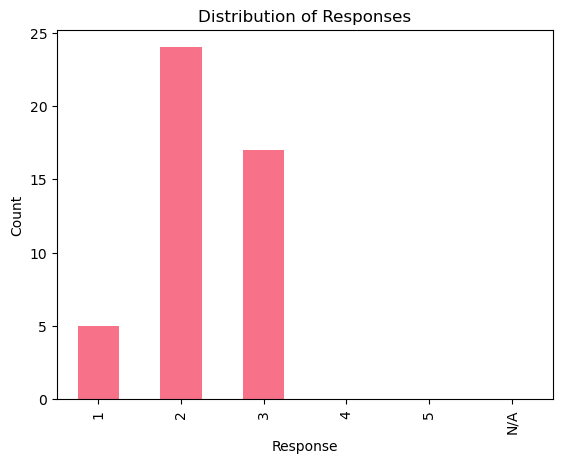

In [24]:

df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar')
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Distribution of Responses')

In [25]:
# compute the average and std scores
average_score = df["response"].replace("N/A", pd.NA).astype(float).mean()
std_score = df["response"].replace("N/A", pd.NA).astype(float).std()
print(f"Average score: {average_score:.2f}")
print(f"Standard deviation of scores: {std_score:.2f}")

Average score: 2.26
Standard deviation of scores: 0.65


In [26]:
is_there_a_good_market(df)

Percentage of positive responses (4-5): 0.00%
Percentage of neutral responses (3): 36.96%
Percentage of negative responses (1-2): 63.04%
Percentage of 'N/A' responses: 0.00%
Mean response: 2.26
Standard deviation of responses: 0.65
VERDICT: There is not a good market for bottled gazpacho.


False

We can also chat with the agents in an ad-hoc way, to get a more detailed understanding if needed.

In [27]:
from tinytroupe.ui import AgentChatJupyterWidget

# Create and display the enhanced chat widget
chat_interface = AgentChatJupyterWidget(people)
chat_interface.display()

In [28]:
control.end()

## Empirical Data Validation
Now let's see how the above matches the same research done with actual real people!

In [29]:
control_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_csv(
            file_path="../data/empirical/07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv",
            experimental_data_type="single_value_per_agent",
            agent_id_column="Responder #",
            value_column="Vote",
            agent_comments_column="Explanation",
            agent_attributes_columns=["Age Range", "Gender Identity", "Political Affiliation", "Racial Or Ethnic Identity"],
            dataset_name="Test Gazpacho Survey"
        )

In [30]:
control_data

SimulationExperimentDataset(name='Test Gazpacho Survey', description='Empirical data loaded from 07.19.2025 - Market Research - Bottled Gazpacho - Raw Data.csv', key_results={'Vote': [4, 1, 1, 5, 3, 4, 2, 4, 1, 1, 3, 2, 2, 5, 4, 3, 3, 5, 4, 2, 3, 5, 3, 3, 5, 1, 3, 4, 3, 1, 1, 4, 3, 3, 2, 1, 4, 3, 4, 2, 1, 1, 2, 1, 2, 5, 2, 4, 3, 5]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 5, 'num_ranks': 5, 'rank_values': [1, 2, 3, 4, 5], 'direction': 'ascending'}}, agent_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50'], agent_justifications=[{'agent_name': '1', 'agent_index': 0, 'justification': 'Yes because it is something i have nev

<Axes: xlabel='0'>

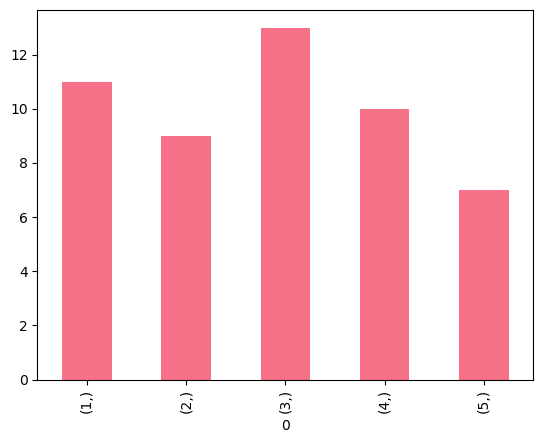

In [31]:
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind="bar")

In [32]:
# Convert string responses to numeric values and rename column to match control_data
df_for_validation = df.copy()
df_for_validation["Vote"] = pd.to_numeric(df_for_validation["response"], errors='coerce')

# Create treatment data with matching column name and data type
treatment_data = SimulationExperimentEmpiricalValidator.read_empirical_data_from_dataframe(
    df=df_for_validation,
    experimental_data_type="single_value_per_agent",
    agent_id_column="name",
    value_column="Vote",
    agent_comments_column="justification",
    dataset_name="Bottled Gazpacho Simulation Results"
)

In [33]:
treatment_data

SimulationExperimentDataset(name='Bottled Gazpacho Simulation Results', description='Empirical data loaded from pandas DataFrame', key_results={'Vote': [1, 2, 2, 2, 3, 2, 1, 3, 2, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 1, 3, 2, 3, 2, 1, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 1, 2, 3]}, result_types={'Vote': 'per_agent'}, data_types={'Vote': 'ranking'}, categorical_mappings={}, ordinal_mappings={}, ranking_info={'Vote': {'min_rank': 1, 'max_rank': 3, 'num_ranks': 3, 'rank_values': [1, 2, 3], 'direction': 'ascending'}}, agent_names=['Clarence Darnell Whitfield', 'Mabel Louise Cartwright', 'Mateo Alejandro Vargas Herrera', 'Clara Meredith Hargrove', 'Isabel Mariela Torres Delgado', 'Loretta Janice Freeman', 'Wesley Grant Carmichael', 'Calvin Theodore Ashford', 'Ethan Marshall Granger', 'Gloria Annette Jefferson', 'Nalani Kealoha Makoa', 'Emilio Javier Salazar Ortega', 'Jordan Kai Navarro-Simms', 'Mariana Estela Rivas', 'Elliot Bradford Winslow', 'Gideon Marshall Treadwell', 'Isabel 

In [34]:
result_ttest = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        output_format="values"
    )

In [35]:
result_ttest.overall_score

0.6423998949296486

In [36]:
result_ttest.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Welch t-test (unequal variance)',
    'control_mean': 2.86,
    'treatment_mean': 2.260869565217391,
    'mean_difference': -0.5991304347826087,
    'percent_change': -20.94861660079052,
    't_statistic': 2.797763737801579,
    'p_value': 0.0066069623665641775,
    'confidence_interval': (-1.0260704789622799, -0.1721903906029375),
    'confidence_level': 0.95,
    'significant': True,
    'degrees_of_freedom': 71.53490763620889,
    'control_sample_size': 50,
    'treatment_sample_size': 46,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.6475520608395781,
    'effect_size': -0.556662770172952}}},
 'test_type': 'welch_t_test',
 'significance_level': 0.05}

In [37]:
result_ttest.semantic_results

In [38]:
result_ks = validate_simulation_experiment_empirically(
        control_data=control_data,
        treatment_data=treatment_data,
        validation_types=["statistical"],
        statistical_test_type="ks_test",
        output_format="values"
    )

In [39]:
result_ks.overall_score

0.7462686567164178

In [40]:
result_ks.statistical_results

{'common_metrics': ['Vote'],
 'test_results': {'treatment': {'Vote': {'test_type': 'Kolmogorov-Smirnov test',
    'control_mean': 2.86,
    'treatment_mean': 2.260869565217391,
    'control_median': 3.0,
    'treatment_median': 2.0,
    'control_std': 1.3554124306434765,
    'treatment_std': 0.6475520608395781,
    'ks_statistic': 0.34,
    'p_value': 0.0055157857578209376,
    'significant': True,
    'control_sample_size': 50,
    'treatment_sample_size': 46,
    'effect_size': 0.34,
    'overlap_coefficient': 0.378070701018574,
    'percentile_differences': {'p25_diff': 0.0,
     'p50_diff': -1.0,
     'p75_diff': -1.0,
     'p90_diff': -2.0,
     'p95_diff': -2.0},
    'interpretation': 'Moderate difference between distributions',
    'confidence_level': 0.95}}},
 'test_type': 'ks_test',
 'significance_level': 0.05}

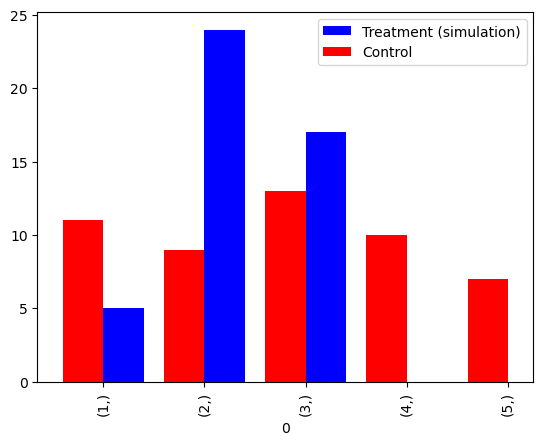

In [41]:
# compare charts. Put both bars in the same plot, for easier comparison
# Need to order the labels in the chart.
fig, ax = plt.subplots()
df["response"].value_counts().reindex(["1", "2", "3", "4", "5", "N/A"]).plot(kind='bar', color='blue', position=0, width=0.4, label="Treatment (simulation)", ax=ax)
pd.DataFrame(control_data.key_results["Vote"]).value_counts().sort_index().plot(kind='bar', color='red', position=1, width=0.4, label="Control", ax=ax)
plt.legend()
plt.show()